In [2]:
!pip install similaritymeasures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 KB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.6.0-py3-none-any.whl size=15480 sha256=6a570ca104eb31d6b4c8e755c5232c8440e7752a4b99bb481c6a2af95ec58c26
  Stored in directory: /root/.cache/pip/wheels/aa/4d/4b/d28f0a3cfd4e43226096568b08ce6ff997e80d3fdc9a1ab080
Successfully built similaritymeasures


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import warnings
import re
from scipy.spatial.distance import directed_hausdorff
import similaritymeasures
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')
%matplotlib inline

from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D, Dropout
import tensorflow.keras.backend as K

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [61]:
df = pd.read_csv('dataset_clean.csv')

In [5]:
df.head()

,departure_Date,Origin_Destination,Target,0,1,2,3,4,5,6,...,335,336,337,338,339,340,341,departure_month,departure_dayofweek,depature_weekend
0,2022-09-22 00:00:00+00:00,DXB-XXX,466,466,469.0,467.0,473.0,458.0,456.0,456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,3,0
1,2022-11-17 00:00:00+00:00,DXB-XXX,314,314,320.0,319.0,314.0,309.0,310.0,303.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,11,3,0
2,2022-10-26 00:00:00+00:00,DXB-XXX,431,431,436.0,447.0,443.0,441.0,448.0,452.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,10,2,0
3,2022-09-19 00:00:00+00:00,DXB-XXX,385,385,392.0,386.0,405.0,400.0,391.0,387.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0,0
4,2022-06-03 00:00:00+00:00,XXX-DXB,507,507,492.0,480.0,508.0,500.0,508.0,509.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4,0


In [62]:
for n,i in df.iterrows():
    target = df.loc[n,'Target']
    for seat in range(0,342):
        df.loc[n,str(seat)] = round(df.loc[n,str(seat)]/target,4)
    

In [7]:
df.head()

,departure_Date,Origin_Destination,Target,0,1,2,3,4,5,6,...,335,336,337,338,339,340,341,departure_month,departure_dayofweek,depature_weekend
0,2022-09-22 00:00:00+00:00,DXB-XXX,466,1,1.0064,1.0021,1.0150,0.9828,0.9785,0.9785,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,9,3,0
1,2022-11-17 00:00:00+00:00,DXB-XXX,314,1,1.0191,1.0159,1.0000,0.9841,0.9873,0.9650,...,0.0000,0.0000,0.0032,0.0032,0.0032,0.0,0.0,11,3,0
2,2022-10-26 00:00:00+00:00,DXB-XXX,431,1,1.0116,1.0371,1.0278,1.0232,1.0394,1.0487,...,0.0023,0.0023,0.0023,0.0023,0.0000,0.0,0.0,10,2,0
3,2022-09-19 00:00:00+00:00,DXB-XXX,385,1,1.0182,1.0026,1.0519,1.0390,1.0156,1.0052,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,9,0,0
4,2022-06-03 00:00:00+00:00,XXX-DXB,507,1,0.9704,0.9467,1.0020,0.9862,1.0020,1.0039,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,6,4,0


In [63]:
df['departure_month'].unique()

array([ 9, 11, 10,  6,  8,  7])

In [64]:
df_val = df[df['departure_month'].isin([11])]
df_train = df[~df['departure_month'].isin([11])]

In [65]:
df['Origin_Destination'].unique()

array(['DXB-XXX', 'XXX-DXB'], dtype=object)

In [66]:
df_train_dxb_xxx = df_train[df_train['Origin_Destination']=='DXB-XXX']
df_train_xxx_dxb = df_train[df_train['Origin_Destination']=='XXX-DXB']

df_val_dxb_xxx = df_val[df_val['Origin_Destination']=='DXB-XXX']
df_val_xxx_dxb = df_val[df_val['Origin_Destination']=='XXX-DXB']

In [67]:
df_train_dxb_xxx.reset_index(drop=True,inplace=True)
df_train_xxx_dxb.reset_index(drop=True,inplace=True)

df_val_dxb_xxx.reset_index(drop=True,inplace=True)
df_val_xxx_dxb.reset_index(drop=True,inplace=True)

In [68]:
_df_val_dxb_xxx = df_val_dxb_xxx.copy()
_df_val_xxx_dxb = df_val_xxx_dxb.copy()

In [69]:
df_val_dxb_xxx.loc[:,'0':'167']=np.nan
df_val_xxx_dxb.loc[:,'0':'167']=np.nan

In [70]:
last_available_data=167

#### Data Preparation - DXB-XXX

In [71]:
X_train_dxb_xxx = df_train_dxb_xxx.loc[:,str(last_available_data+1):'341']
X_train_dxb_xxx = X_train_dxb_xxx[X_train_dxb_xxx.columns[::-1]].values
X_train_dxb_xxx = X_train_dxb_xxx.reshape(X_train_dxb_xxx.shape[0],-1,1)

Y_train_dxb_xxx = df_train_dxb_xxx.loc[:,'0':str(last_available_data)]
Y_train_dxb_xxx = Y_train_dxb_xxx[Y_train_dxb_xxx.columns[::-1]].values
Y_train_dxb_xxx = Y_train_dxb_xxx.reshape(Y_train_dxb_xxx.shape[0],-1,1)

X_val_dxb_xxx = df_val_dxb_xxx.loc[:,str(last_available_data+1):'341']
X_val_dxb_xxx = X_val_dxb_xxx[X_val_dxb_xxx.columns[::-1]].values
X_val_dxb_xxx = X_val_dxb_xxx.reshape(X_val_dxb_xxx.shape[0],-1,1)

Y_val_dxb_xxx = df_val_dxb_xxx.loc[:,'0':str(last_available_data)]
Y_val_dxb_xxx = Y_val_dxb_xxx[Y_val_dxb_xxx.columns[::-1]].values
Y_val_dxb_xxx = Y_val_dxb_xxx.reshape(Y_val_dxb_xxx.shape[0],-1,1)

In [72]:
X_train_dxb_xxx.shape

(151, 174, 1)

In [73]:
Y_train_dxb_xxx.shape

(151, 168, 1)

In [74]:
X_val_dxb_xxx.shape

(30, 174, 1)

In [75]:
Y_val_dxb_xxx.shape

(30, 168, 1)

### Data Preparation - XXX-DXB

In [76]:
X_train_xxx_dxb = df_train_xxx_dxb.loc[:,str(last_available_data+1):'341']
X_train_xxx_dxb = X_train_xxx_dxb[X_train_xxx_dxb.columns[::-1]].values
X_train_xxx_dxb = X_train_xxx_dxb.reshape(X_train_xxx_dxb.shape[0],-1,1)

Y_train_xxx_dxb = df_train_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_train_xxx_dxb = Y_train_xxx_dxb[Y_train_xxx_dxb.columns[::-1]].values
Y_train_xxx_dxb = Y_train_xxx_dxb.reshape(Y_train_xxx_dxb.shape[0],-1,1)

X_val_xxx_dxb = df_val_xxx_dxb.loc[:,str(last_available_data+1):'341']
X_val_xxx_dxb = X_val_xxx_dxb[X_val_xxx_dxb.columns[::-1]].values
X_val_xxx_dxb = X_val_xxx_dxb.reshape(X_val_xxx_dxb.shape[0],-1,1)

Y_val_xxx_dxb = df_val_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_val_xxx_dxb = Y_val_xxx_dxb[Y_val_xxx_dxb.columns[::-1]].values
Y_val_xxx_dxb = Y_val_xxx_dxb.reshape(Y_val_xxx_dxb.shape[0],-1,1)

In [81]:
n_steps = 174 # we use 12h window
n_lookup = 168 # predict series of 4 values in time t1, t2, t3, t4
n_features = X_train_dxb_xxx.shape[2]

In [84]:
model_dxb_xxx = Sequential()
model_dxb_xxx.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_dxb_xxx.add(RepeatVector(n_lookup))
model_dxb_xxx.add(LSTM(100, activation='tanh', return_sequences=True))
model_dxb_xxx.add(TimeDistributed(Dense(1)))
model_dxb_xxx.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')

model_dxb_xxx.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 168, 100)         0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 168, 100)          80400     
                                                                 
 time_distributed_1 (TimeDis  (None, 168, 1)           101       
 tributed)                                                       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


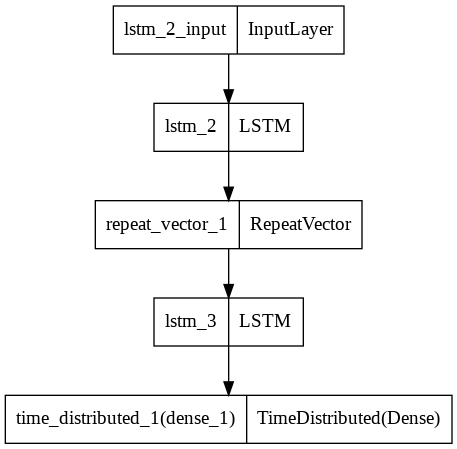

In [87]:
tf.keras.utils.plot_model(model_dxb_xxx)

In [85]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [89]:
N_SAMPLE = 20
#yhat_tcm = np.zeros((Xtest_sub.shape[0],n_lookup))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_dxb_xxx.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')
    history_tcm = model_dxb_xxx.fit(X_train_dxb_xxx, Y_train_dxb_xxx, 
                                validation_data = (X_val_dxb_xxx, Y_val_dxb_xxx), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    #yhat_tcm += np.expm1(model_tcm.predict(Xtest_sub)).reshape(-1,n_lookup)

#yhat_tcm = yhat_tcm / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

In [92]:
model_dxb_xxx.evaluate(X_val_dxb_xxx, Y_val_dxb_xxx, verbose=0)

nan

In [94]:
_Y_val_dxb_xxx = model_dxb_xxx.predict(X_val_dxb_xxx)

1/1 [==============================] - 0s 90ms/step


In [101]:
df_val_dxb_xxx.shape

(30, 348)

In [117]:
for n, i in df_val_dxb_xxx.iterrows():
  df_val_dxb_xxx.loc[n,'0':str(last_available_data)] = _Y_val_dxb_xxx[n].reshape(-1)[::-1]

In [118]:
df_val_dxb_xxx.head()

,departure_Date,Origin_Destination,Target,0,1,2,3,4,5,6,...,335,336,337,338,339,340,341,departure_month,departure_dayofweek,depature_weekend
0,2022-11-17 00:00:00+00:00,DXB-XXX,314,0.776863,0.776843,0.776822,0.776800,0.776776,0.776750,0.776722,...,0.0,0.0,0.0032,0.0032,0.0032,0.0,0.0,11,3,0
1,2022-11-19 00:00:00+00:00,DXB-XXX,487,0.789276,0.789077,0.788870,0.788655,0.788432,0.788200,0.787960,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,11,5,1
2,2022-11-07 00:00:00+00:00,DXB-XXX,451,0.795687,0.795471,0.795253,0.795031,0.794807,0.794580,0.794350,...,0.0,0.0,0.0022,0.0022,0.0000,0.0,0.0,11,0,0
3,2022-11-01 00:00:00+00:00,DXB-XXX,444,0.784667,0.784559,0.784447,0.784329,0.784206,0.784076,0.783941,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,11,1,0
4,2022-11-14 00:00:00+00:00,DXB-XXX,408,0.776760,0.776739,0.776717,0.776694,0.776669,0.776641,0.776613,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,11,0,0


In [111]:
v=0

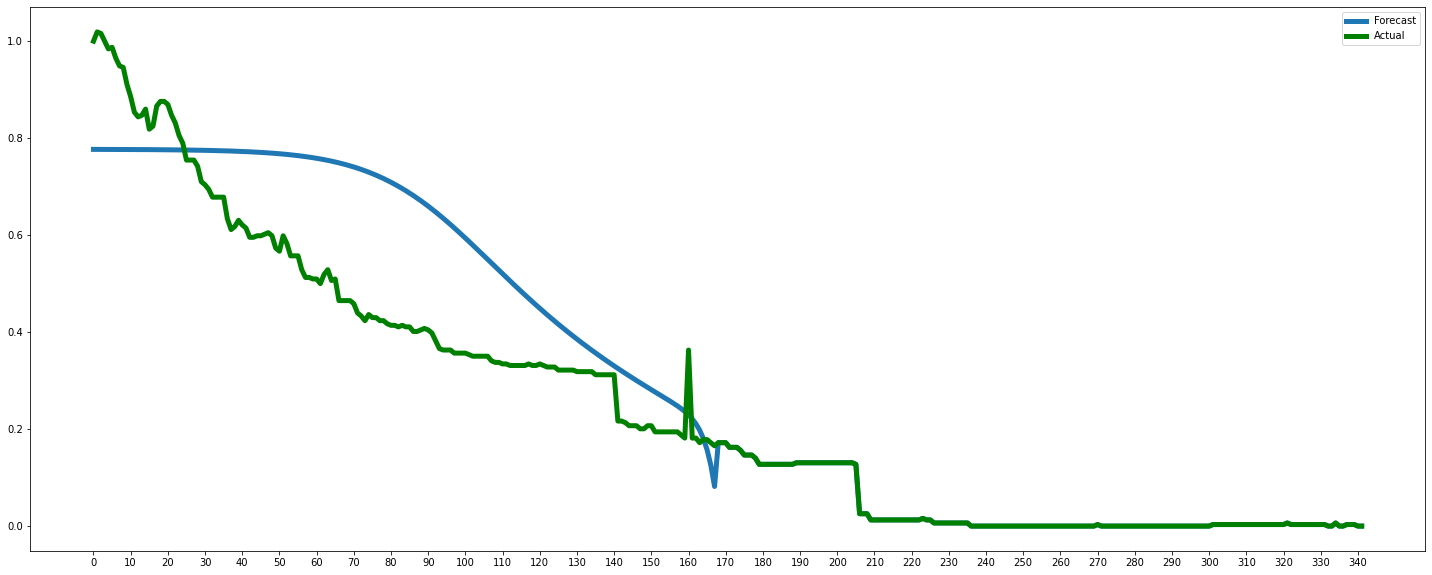

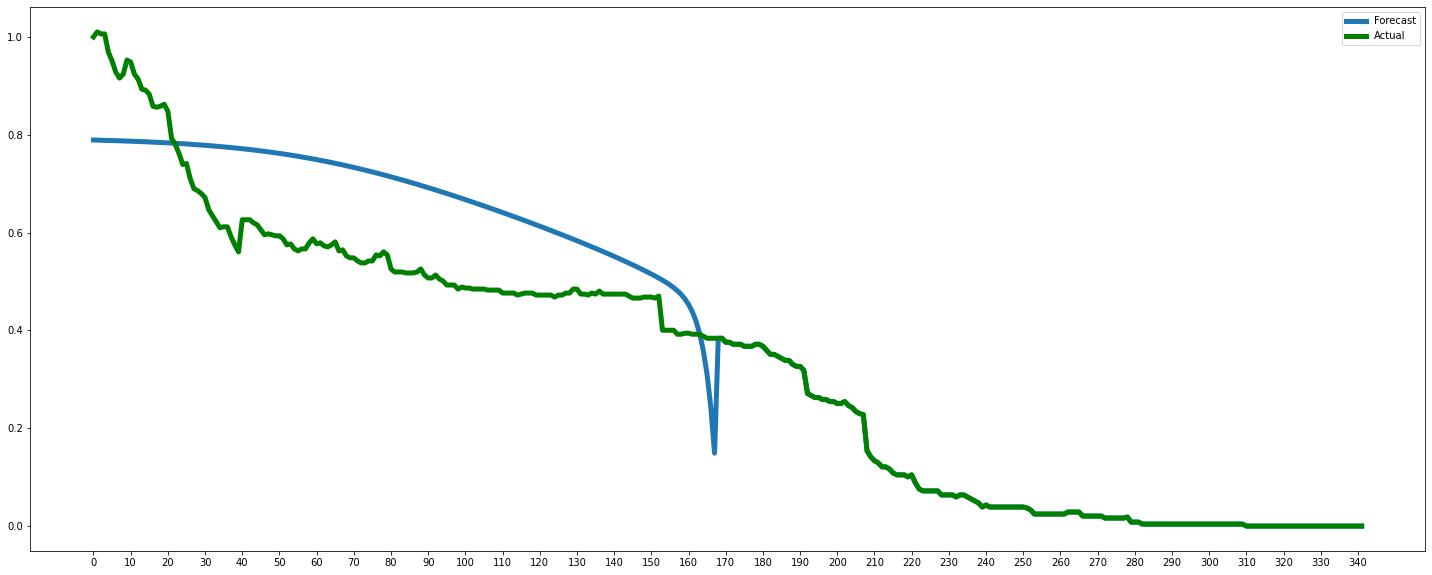

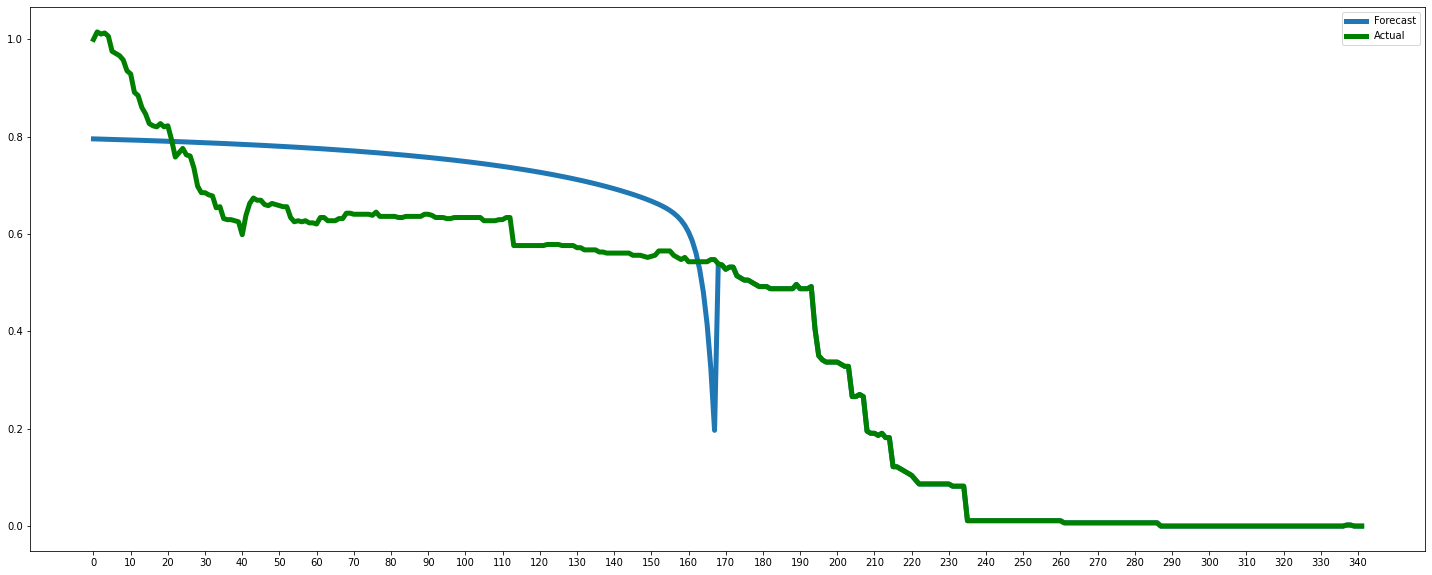

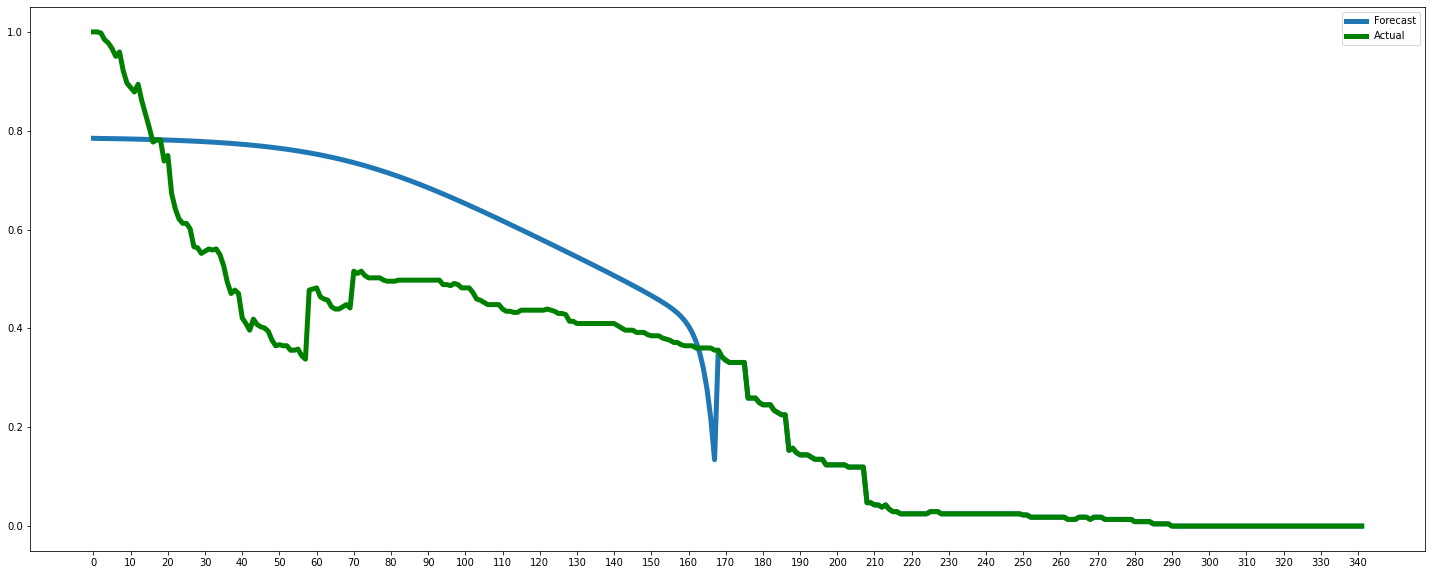

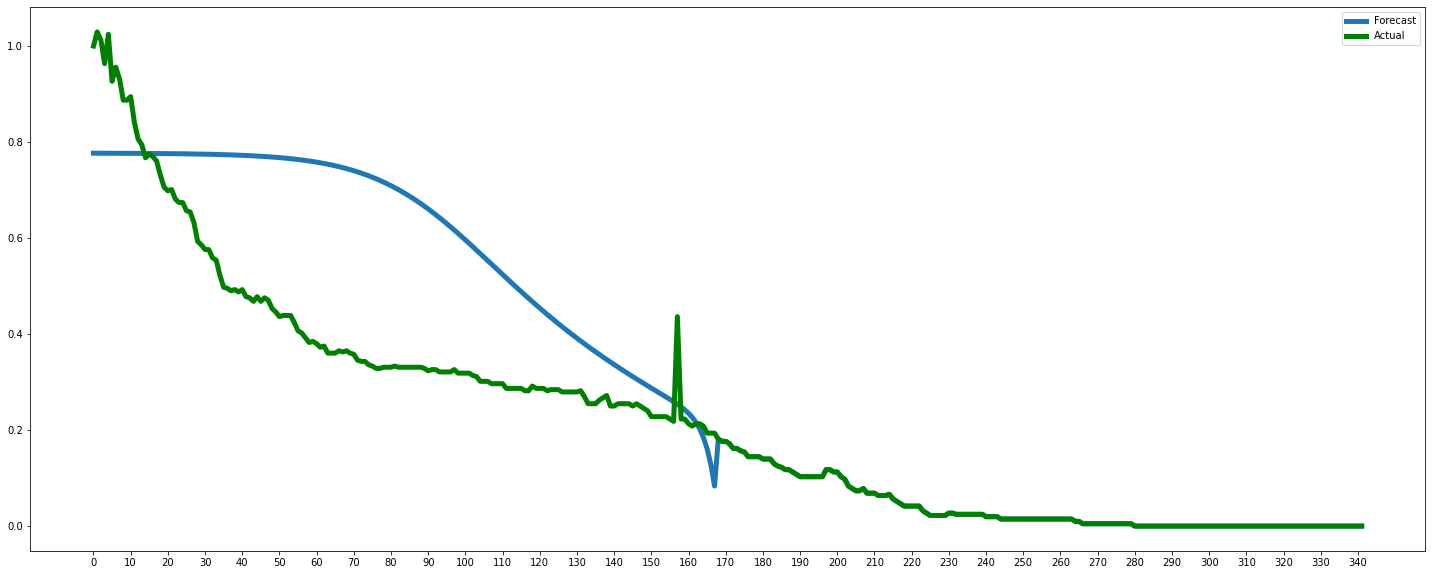

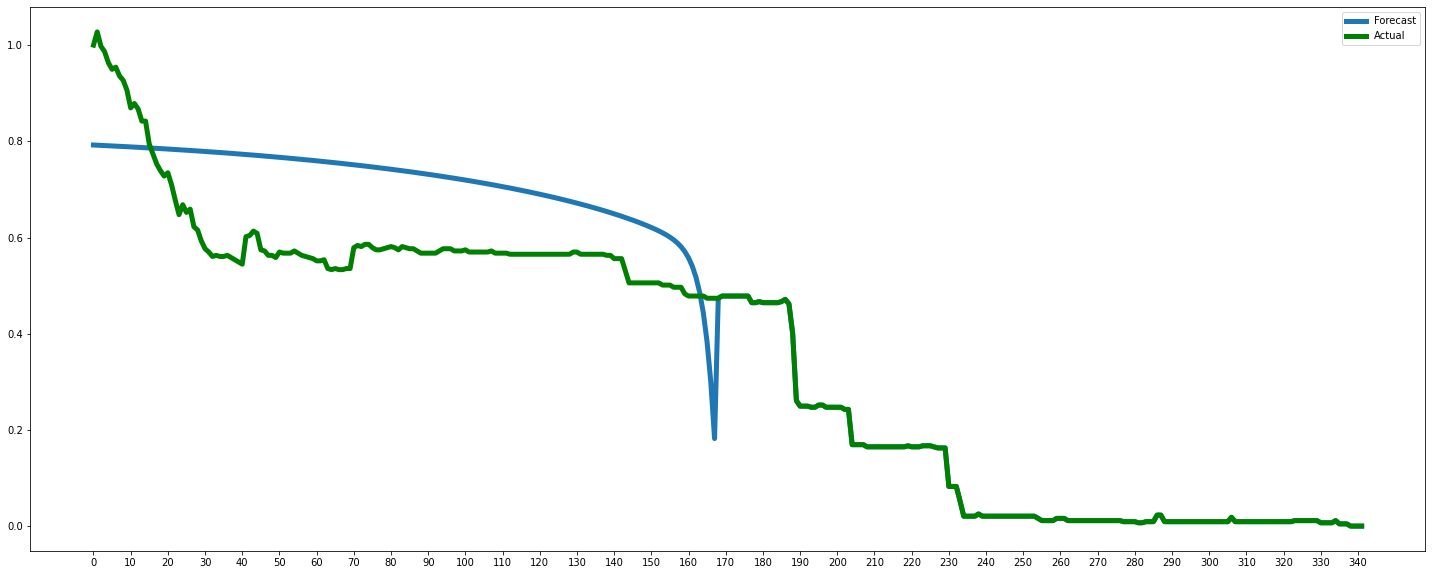

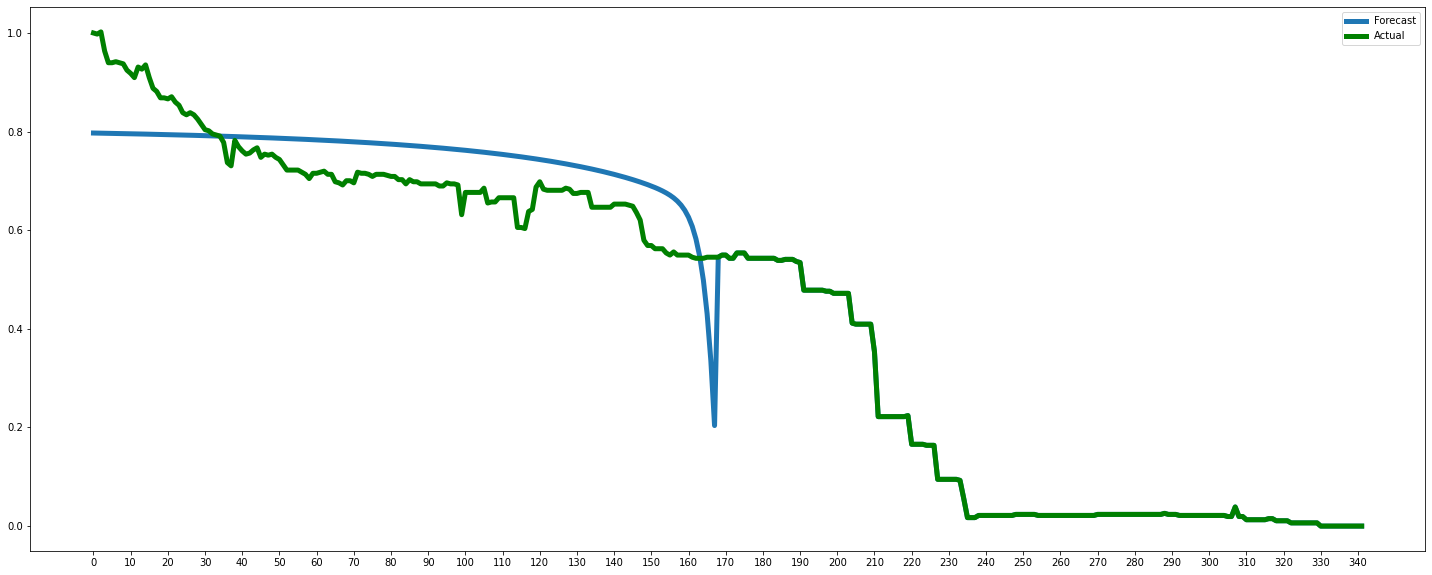

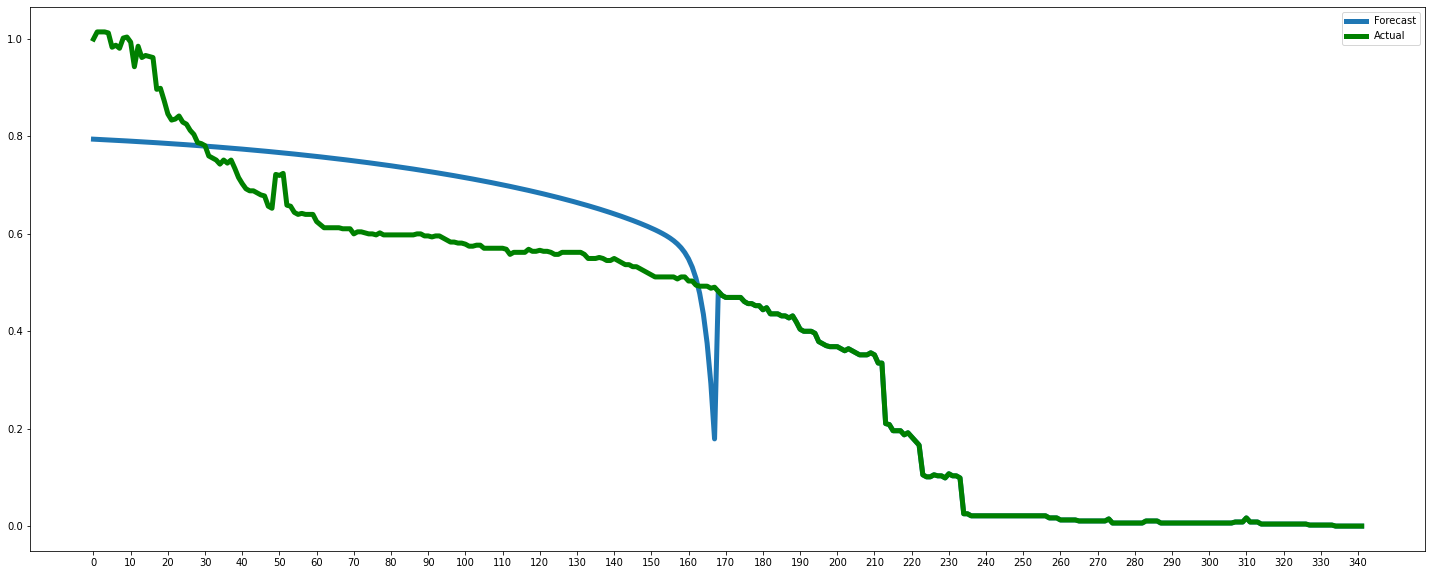

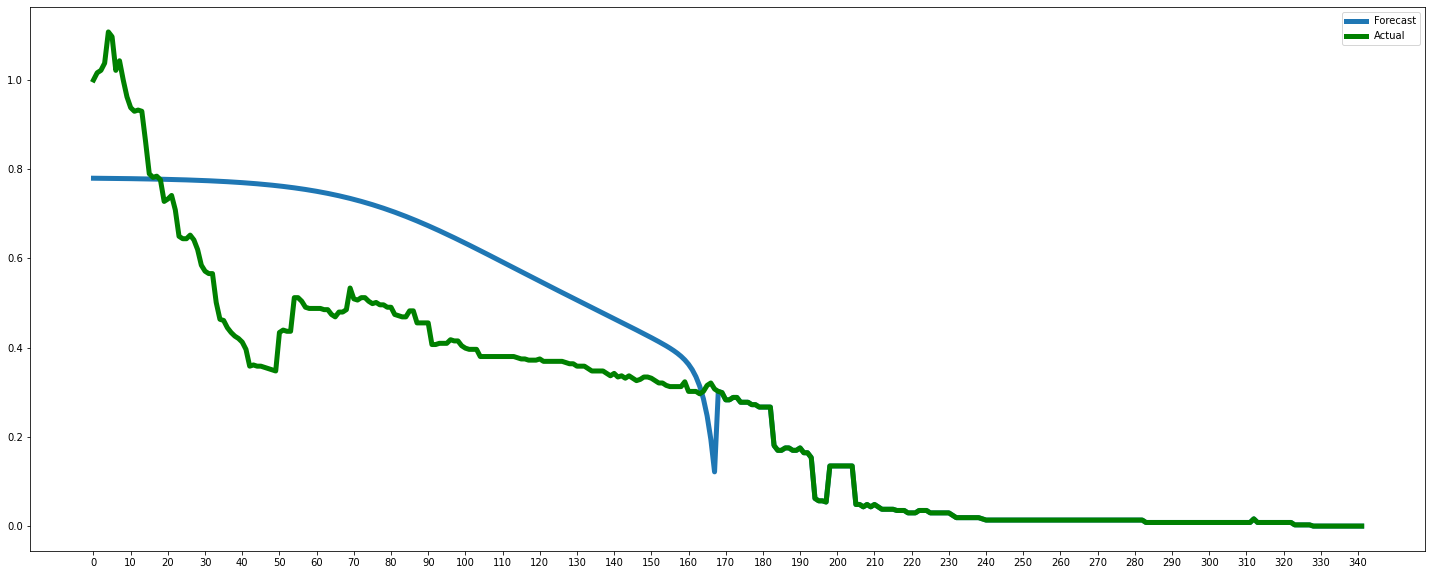

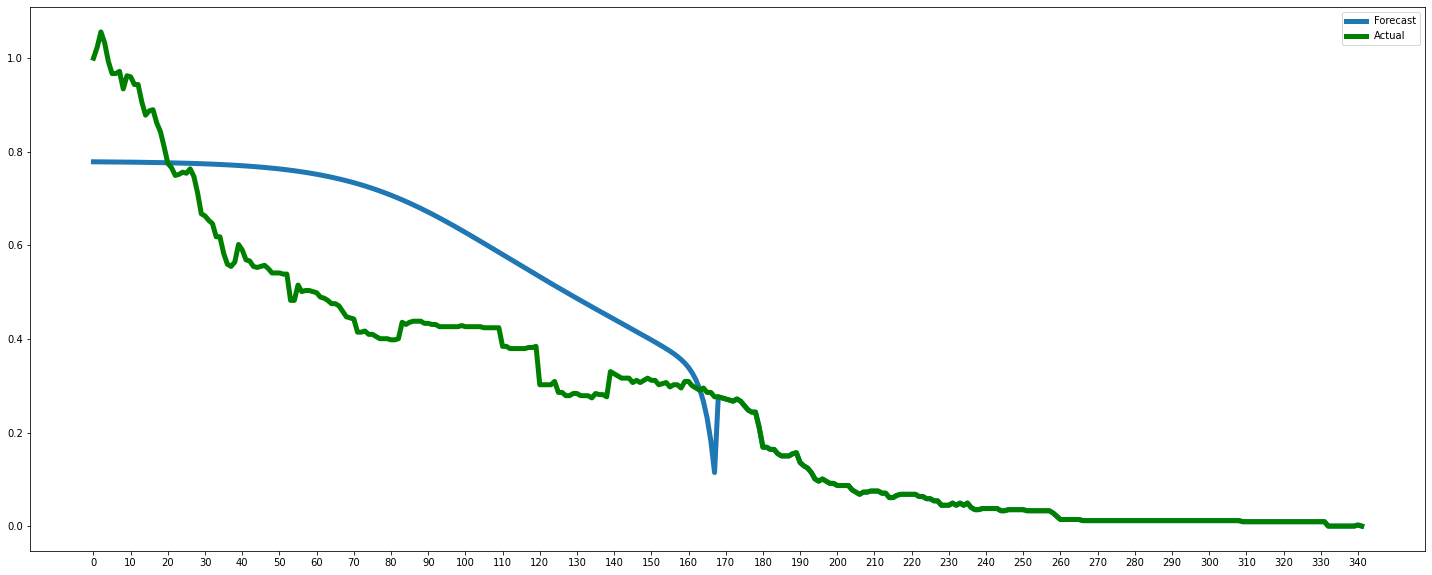

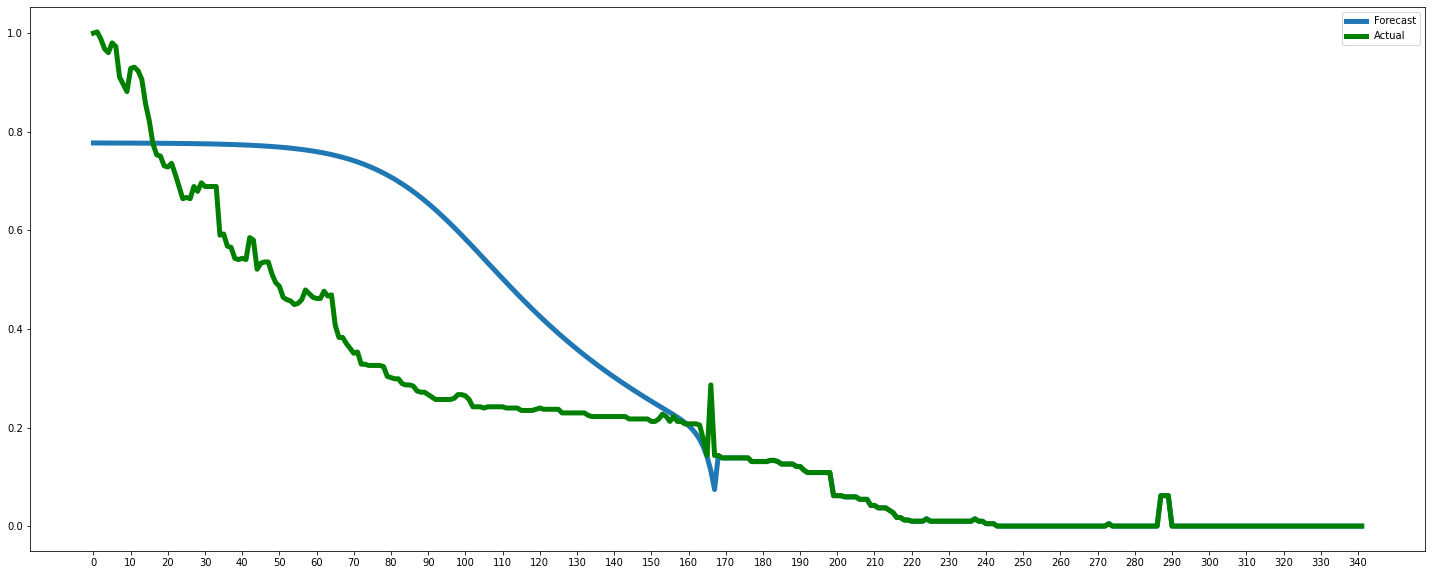

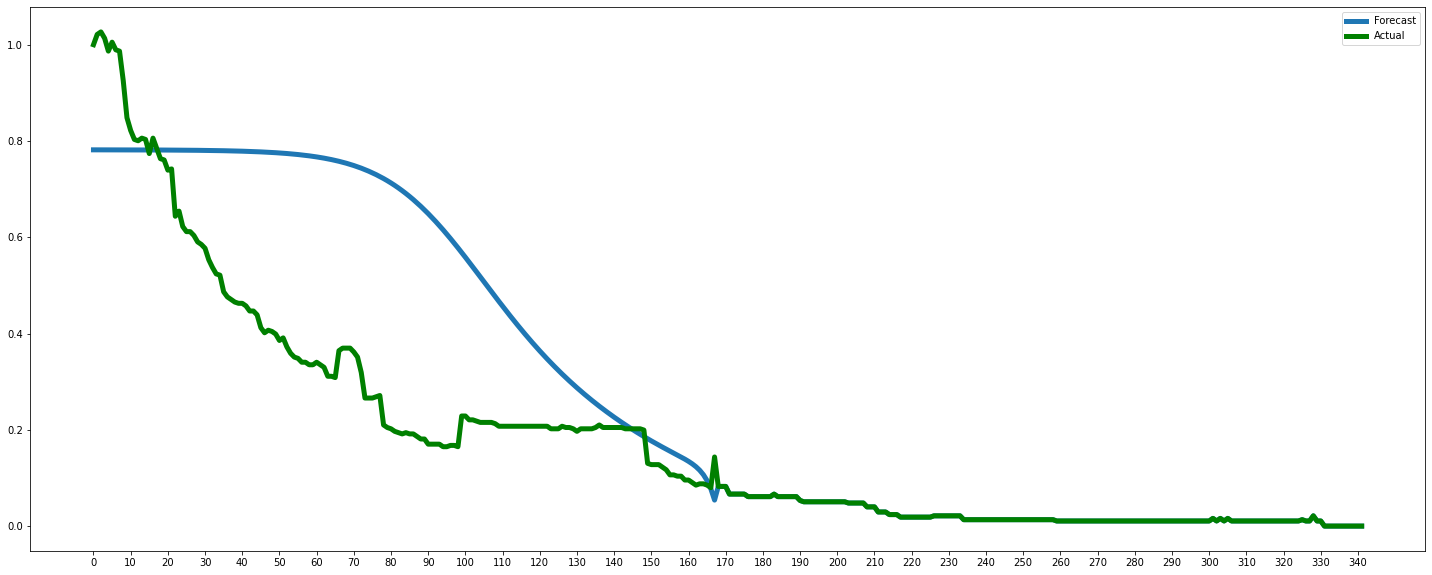

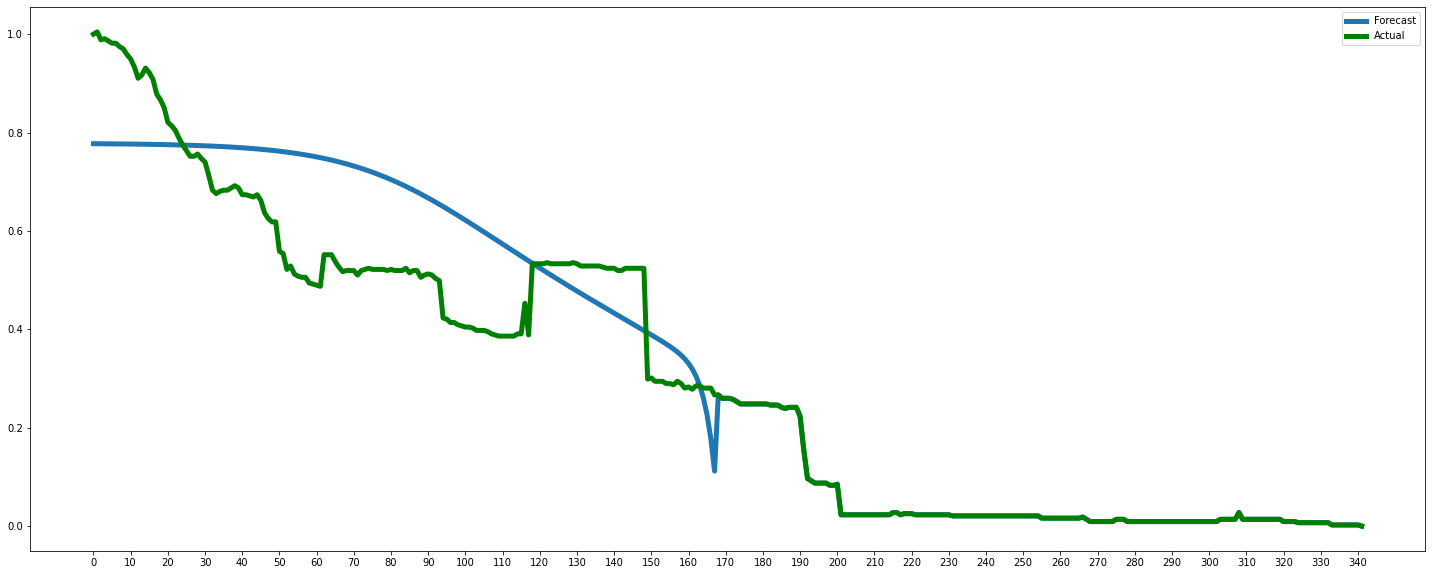

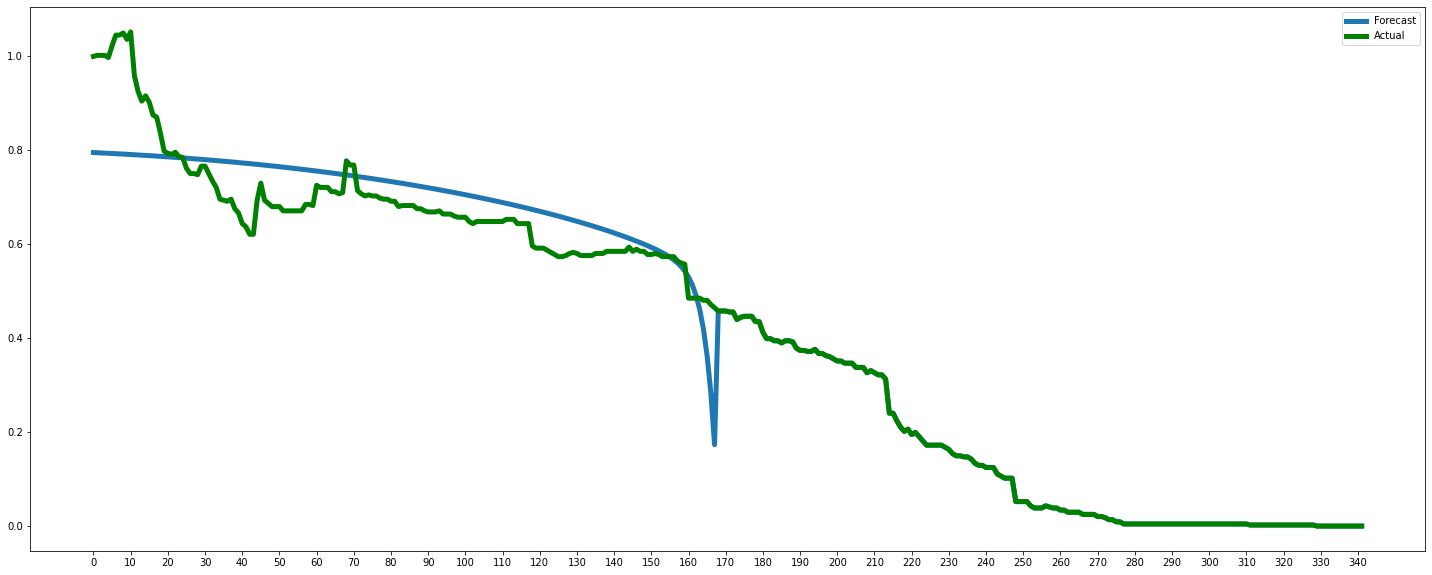

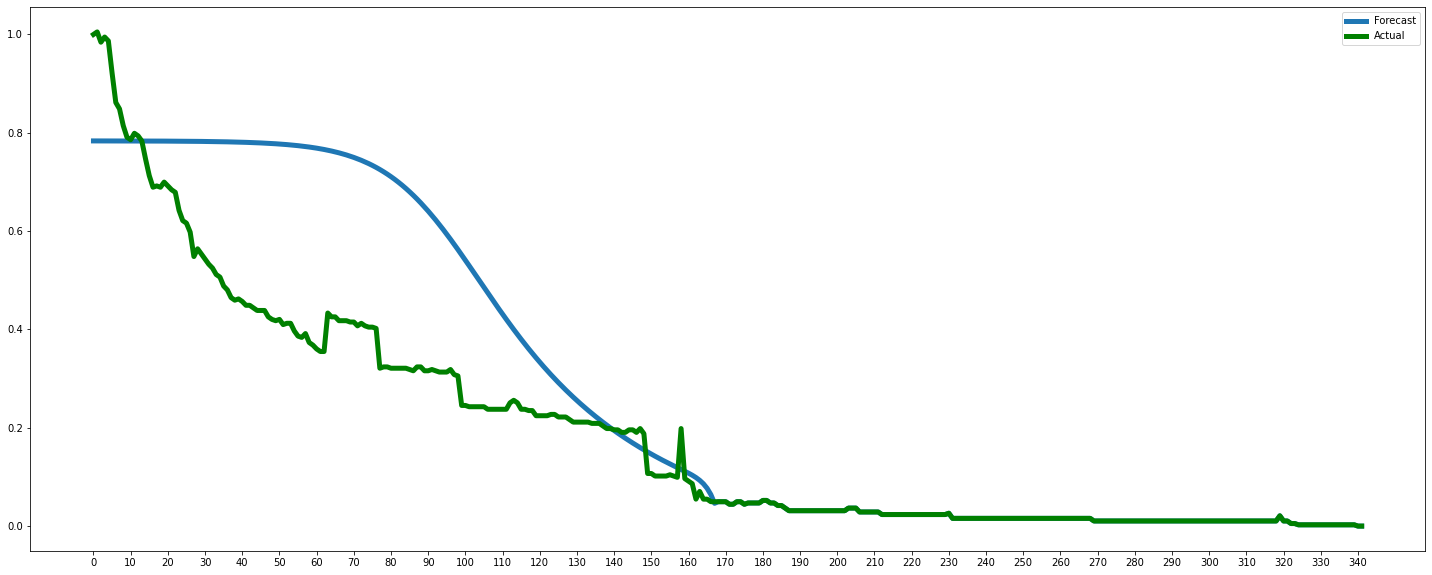

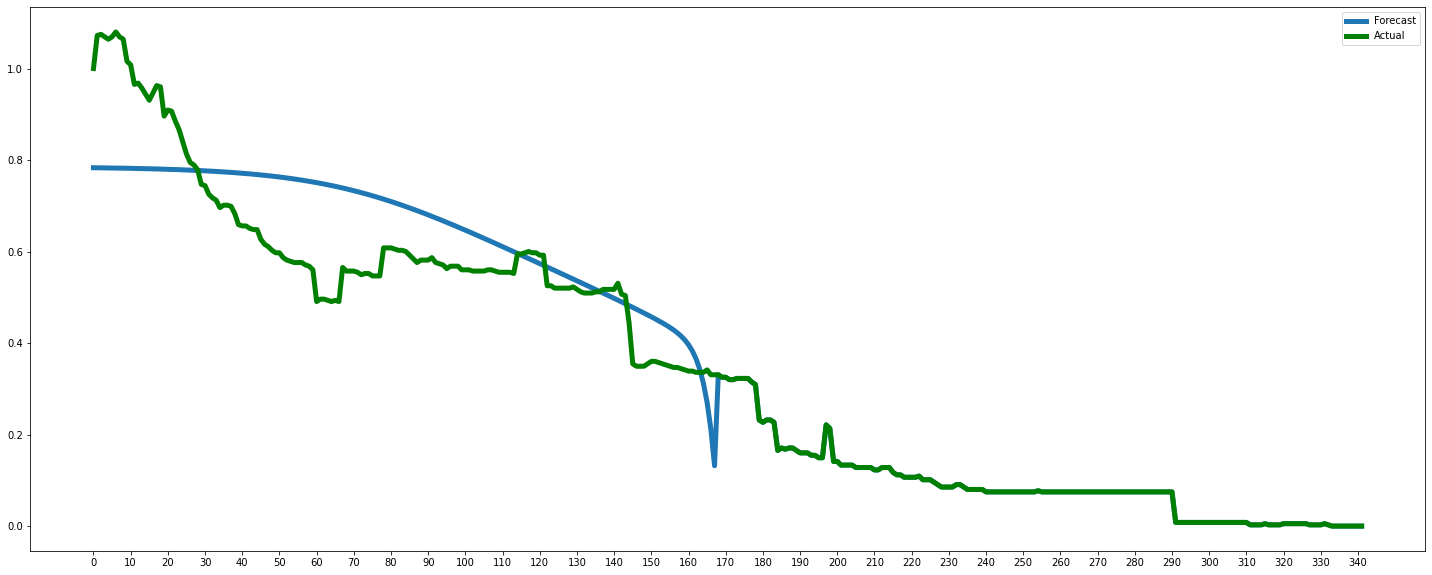

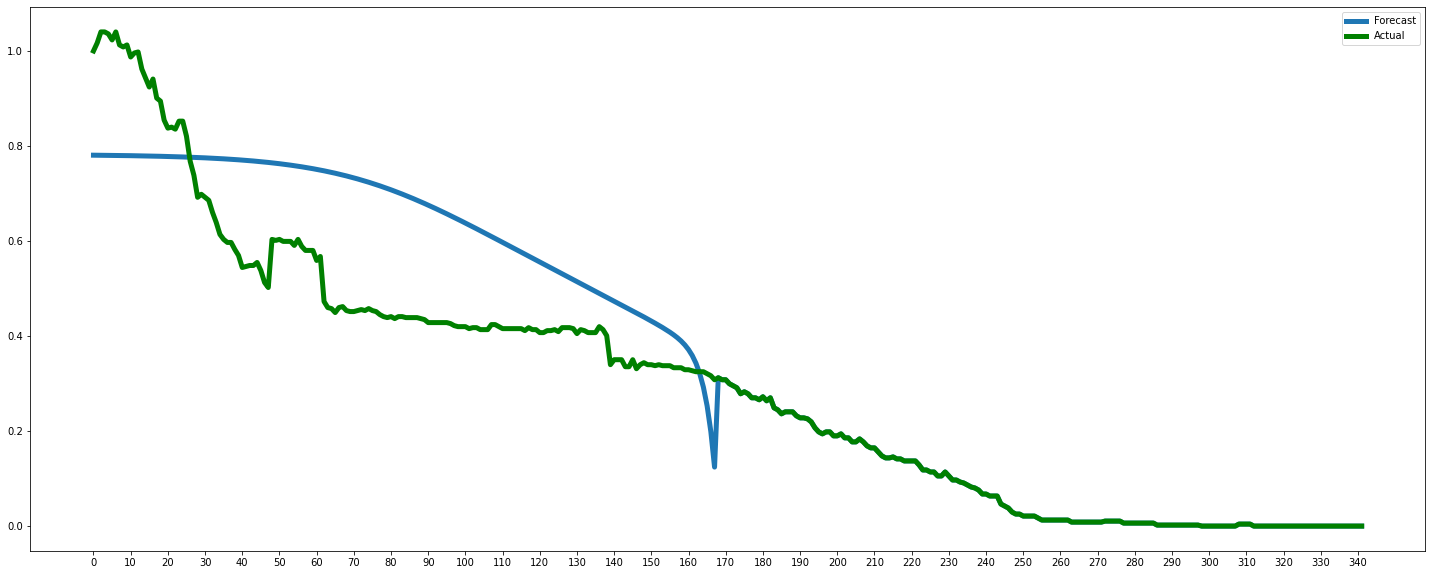

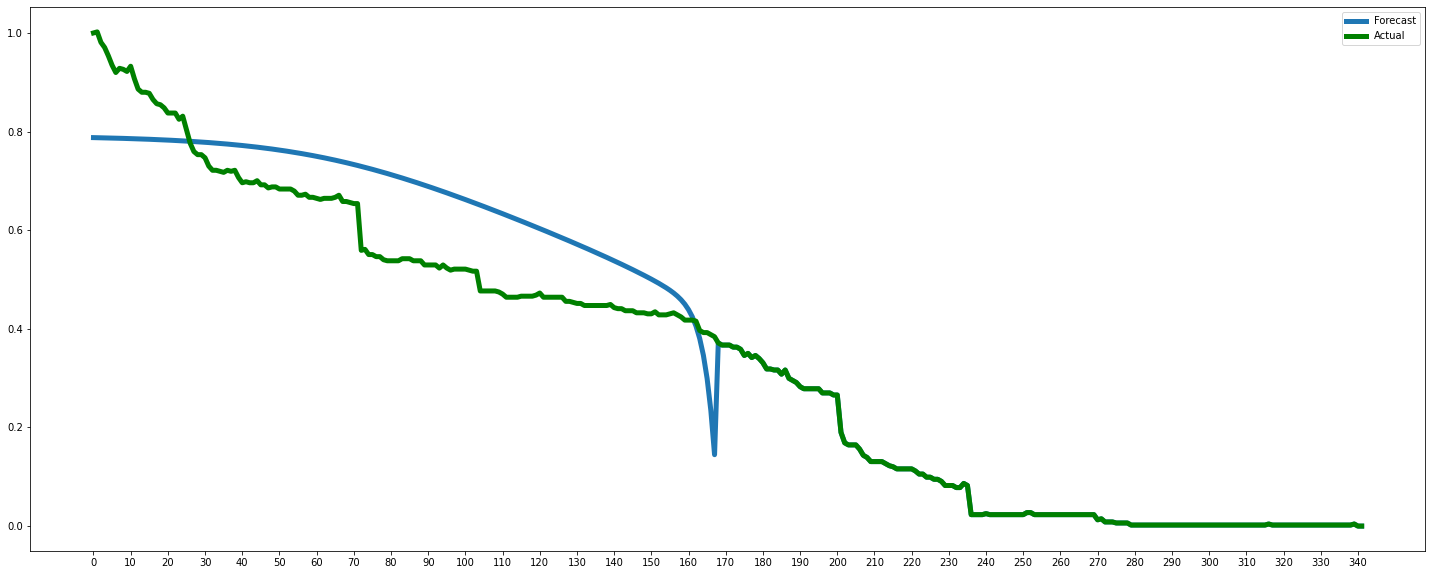

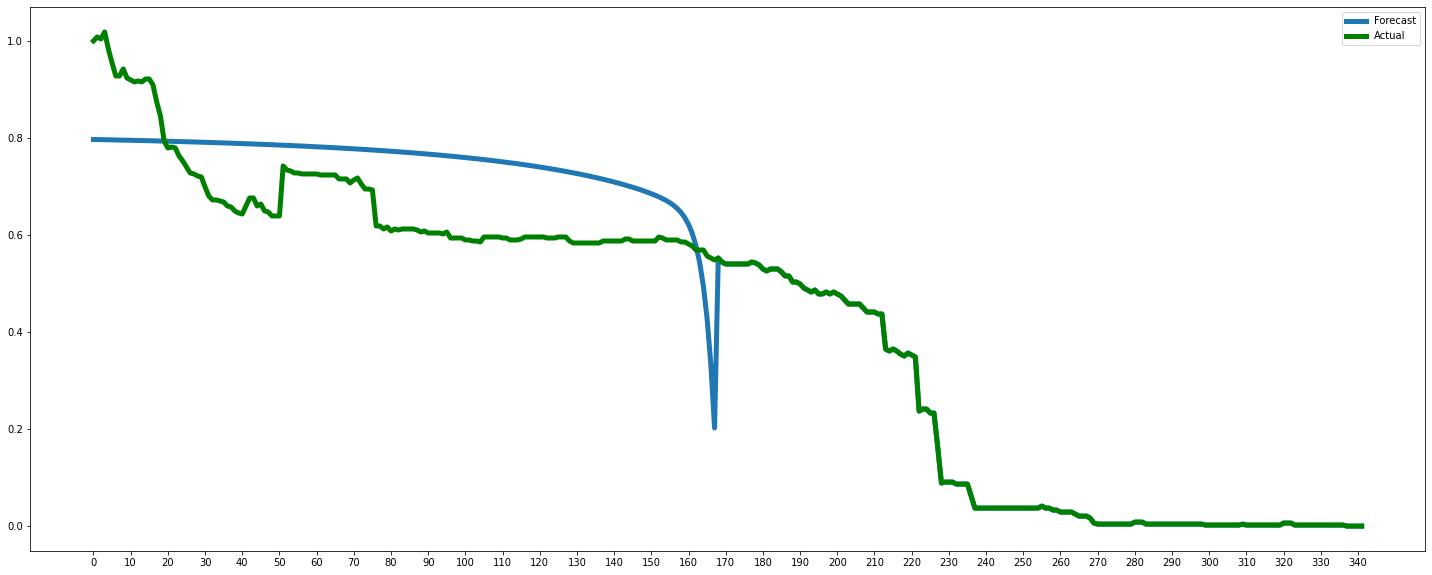

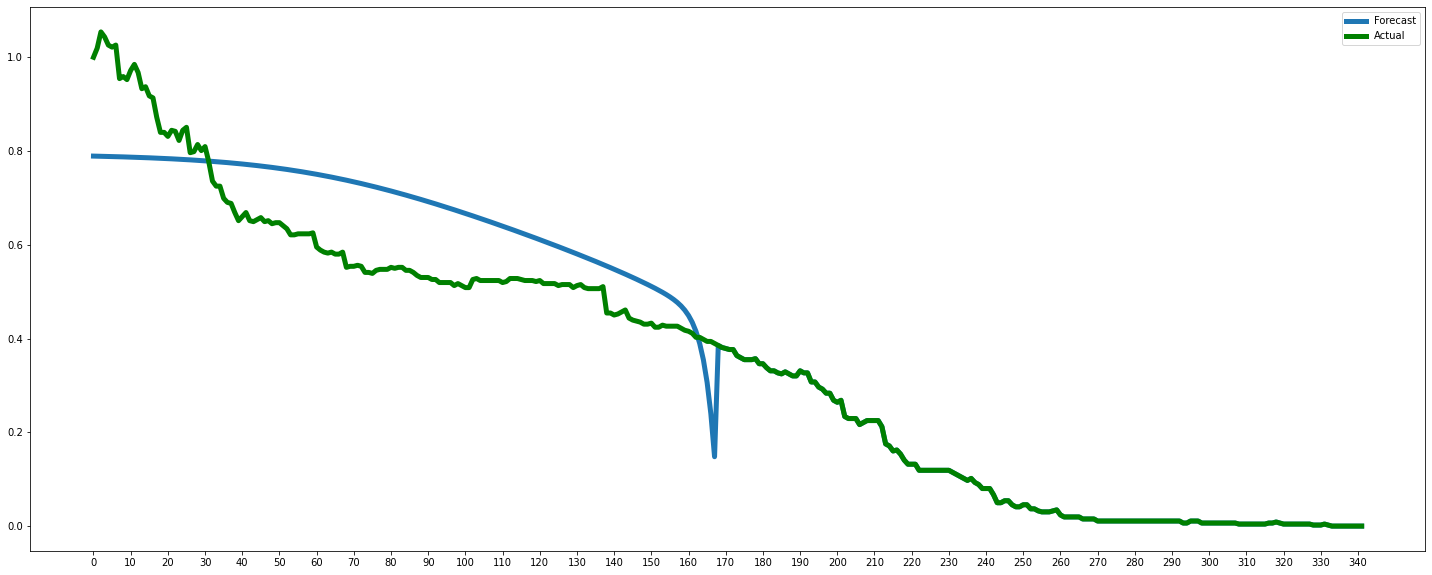

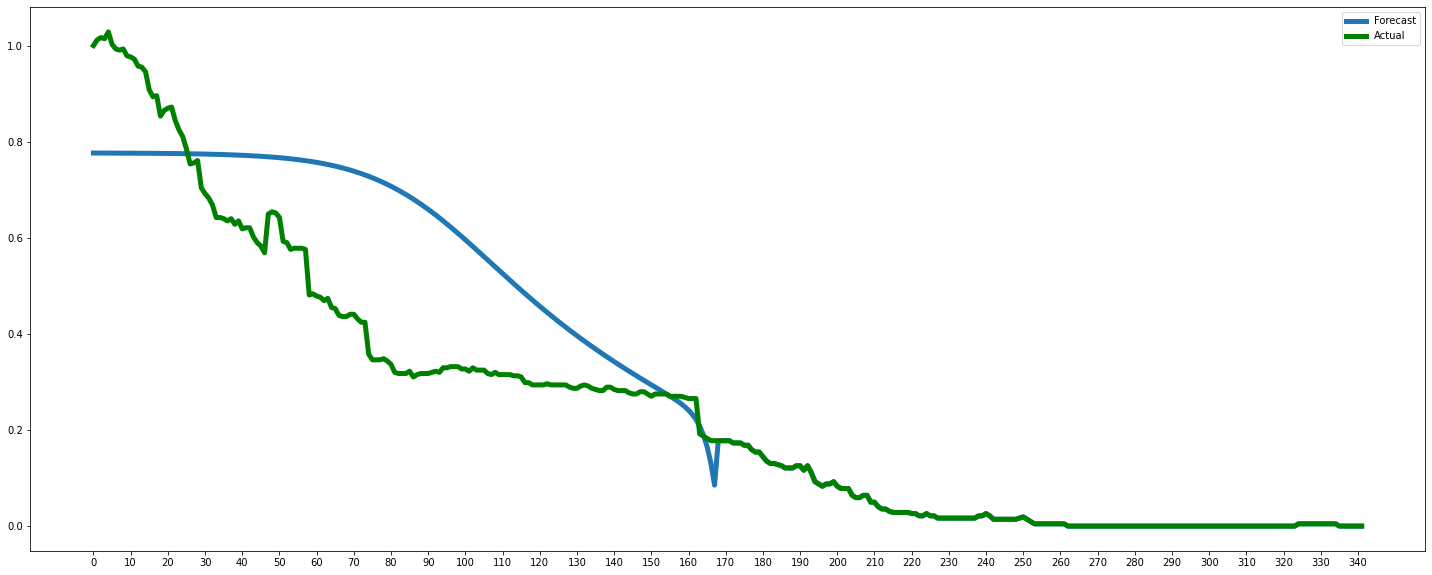

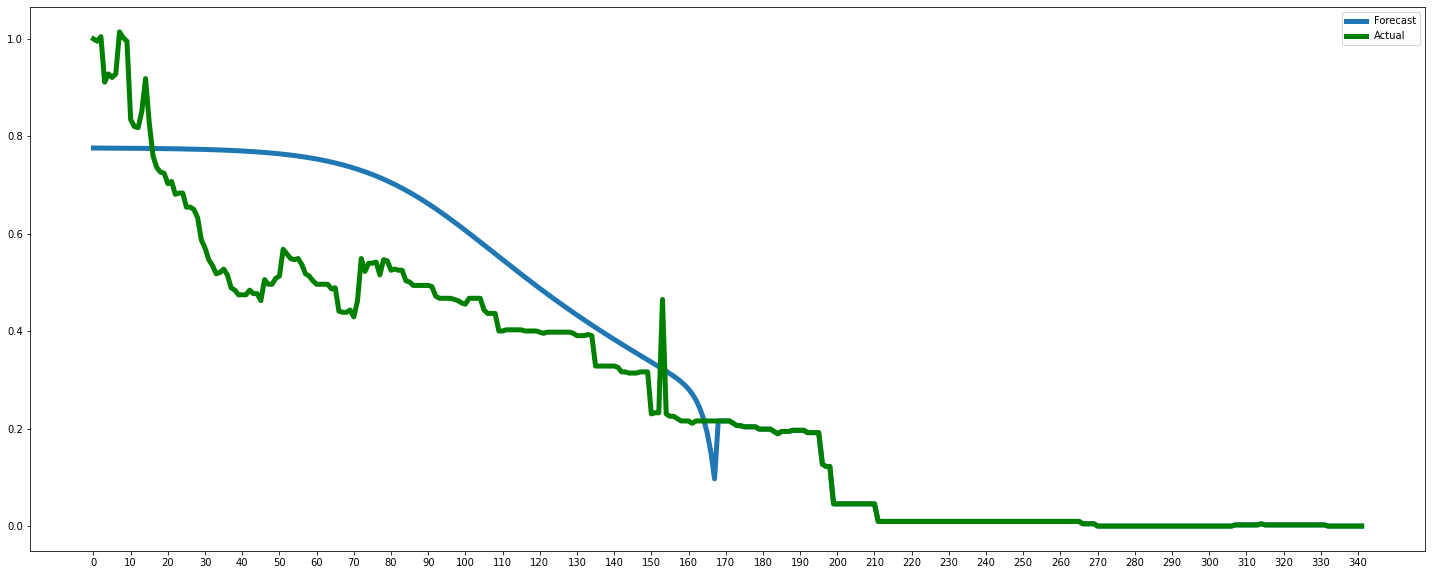

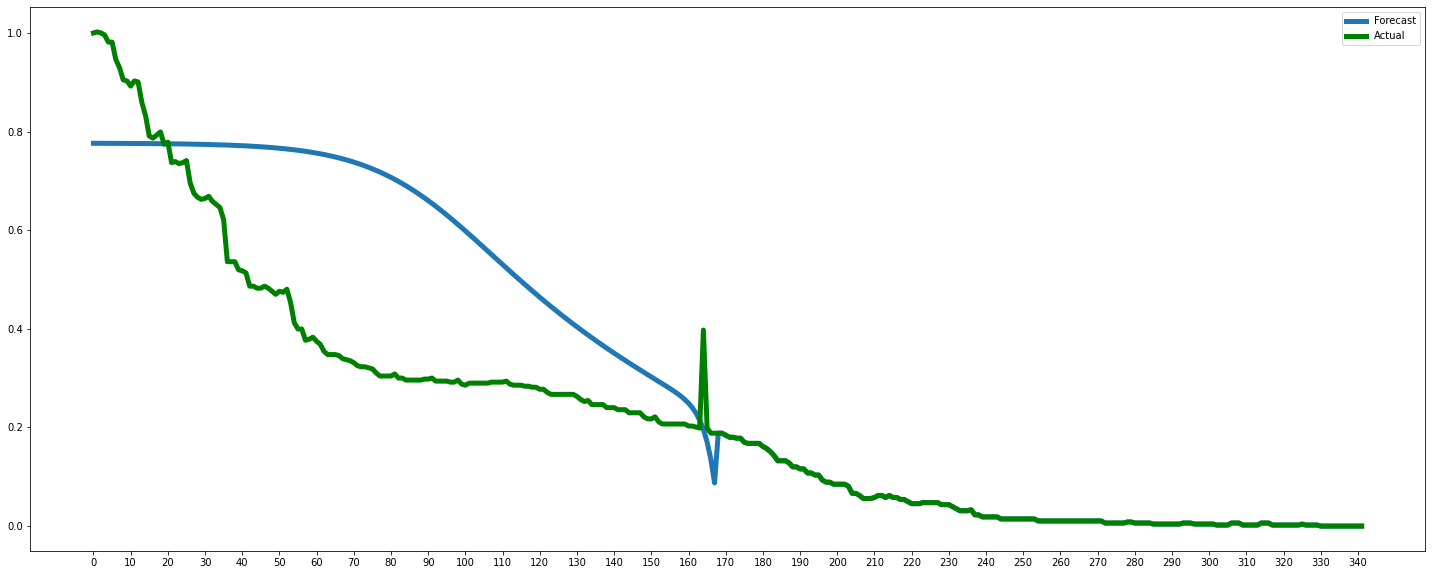

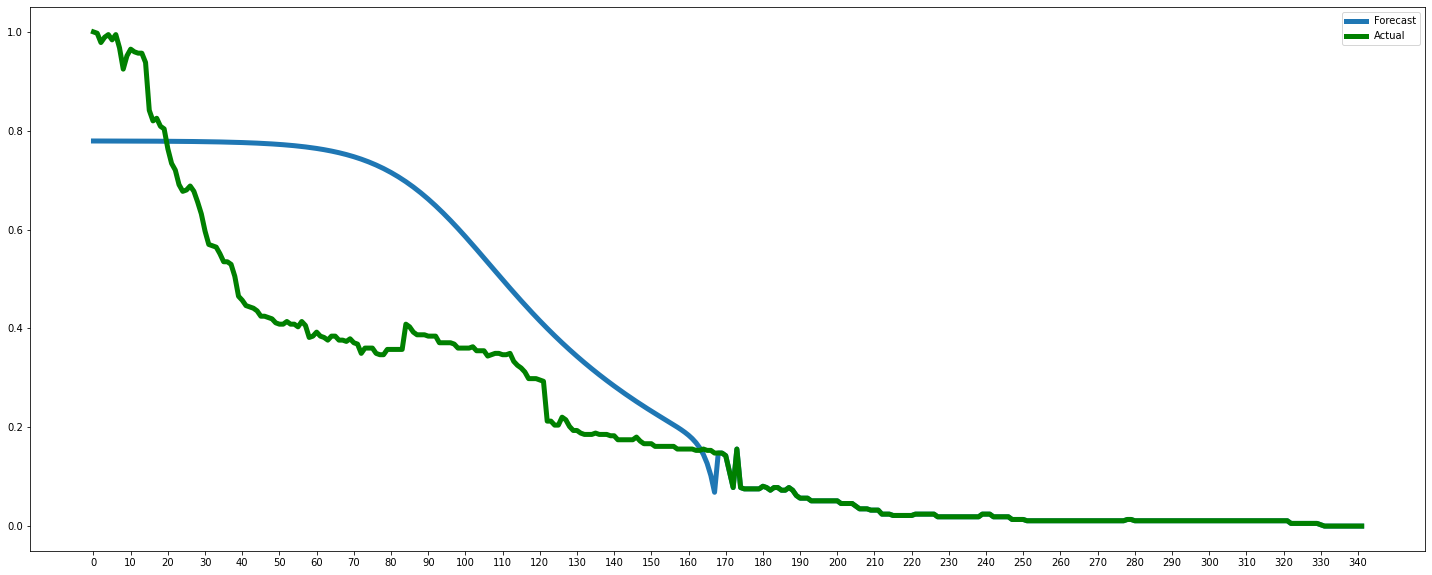

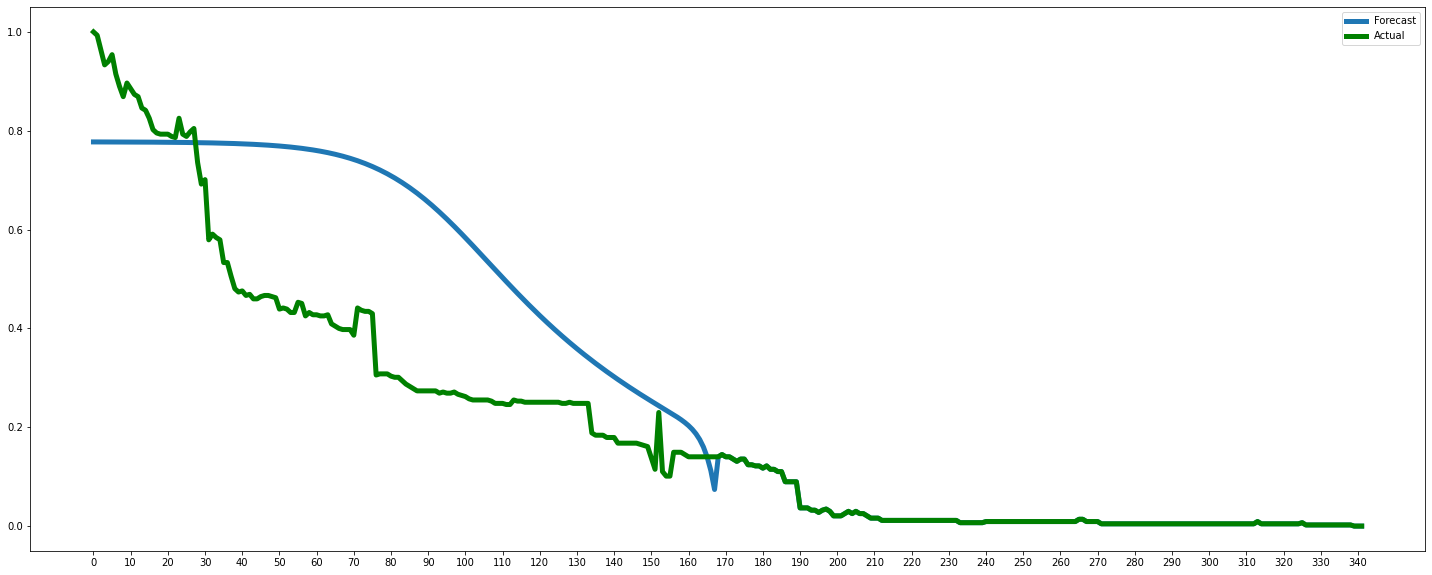

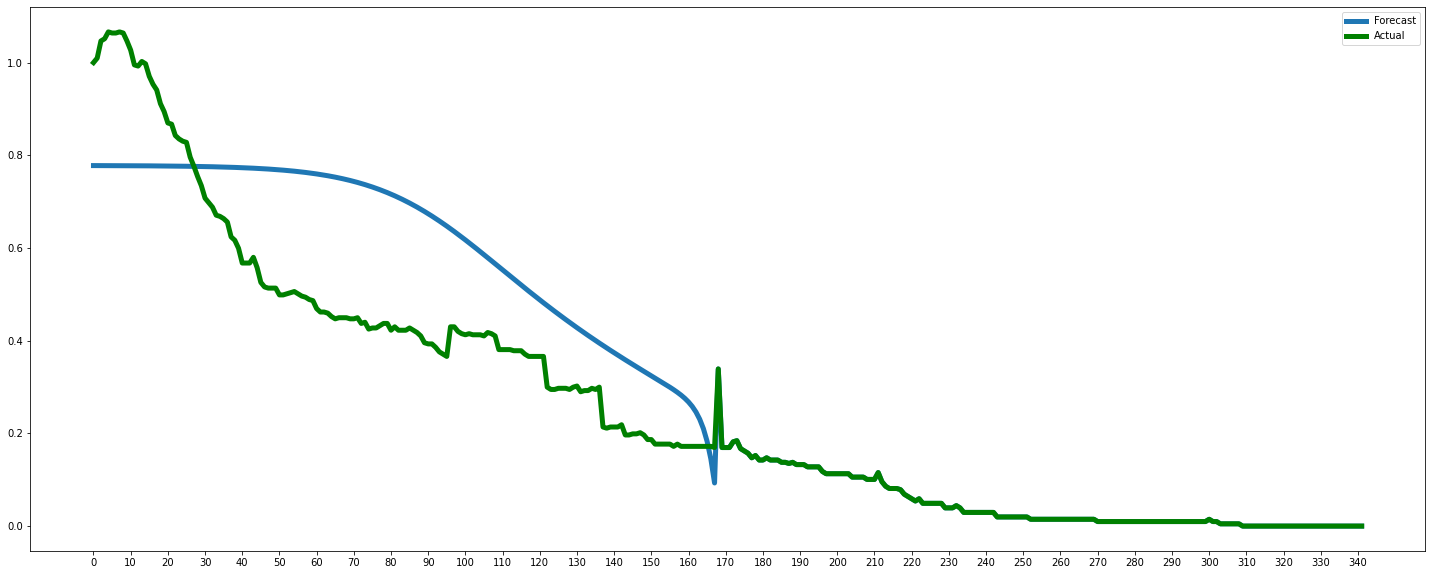

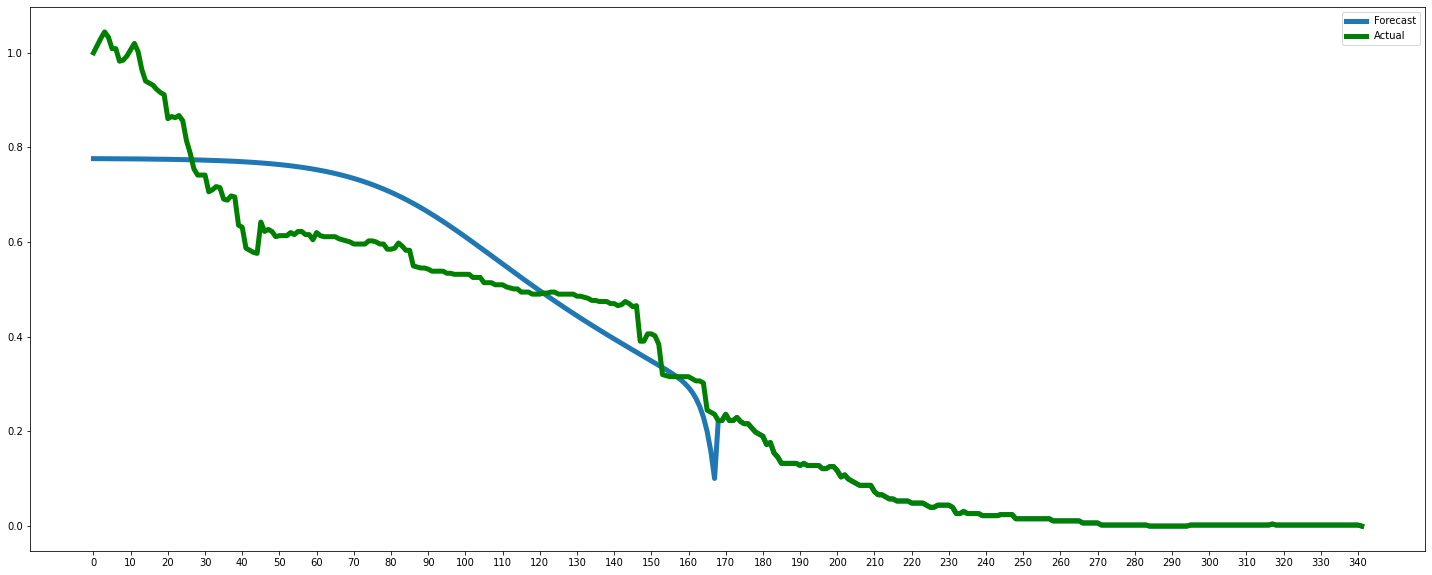

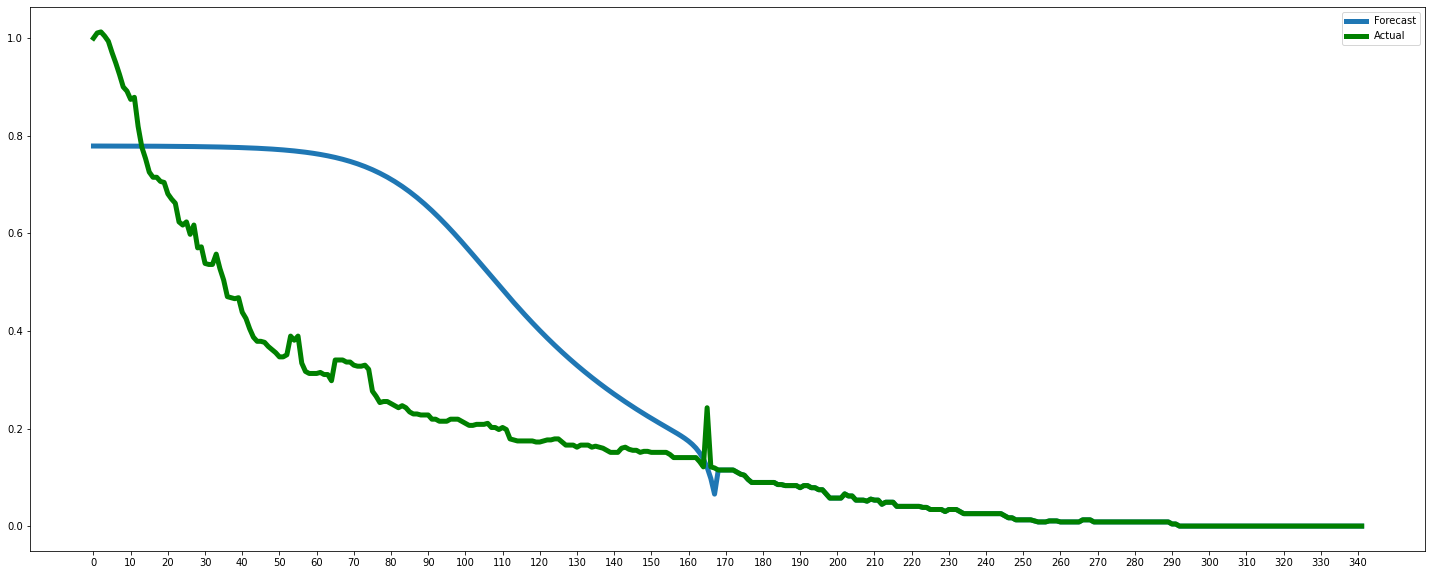

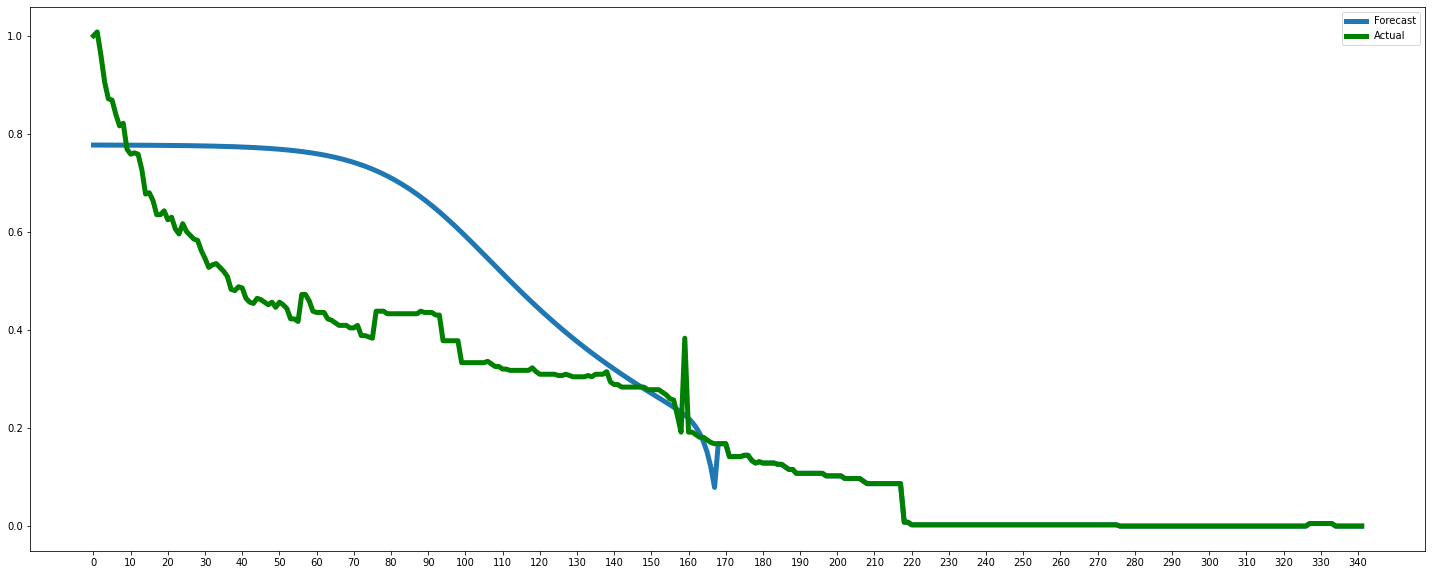

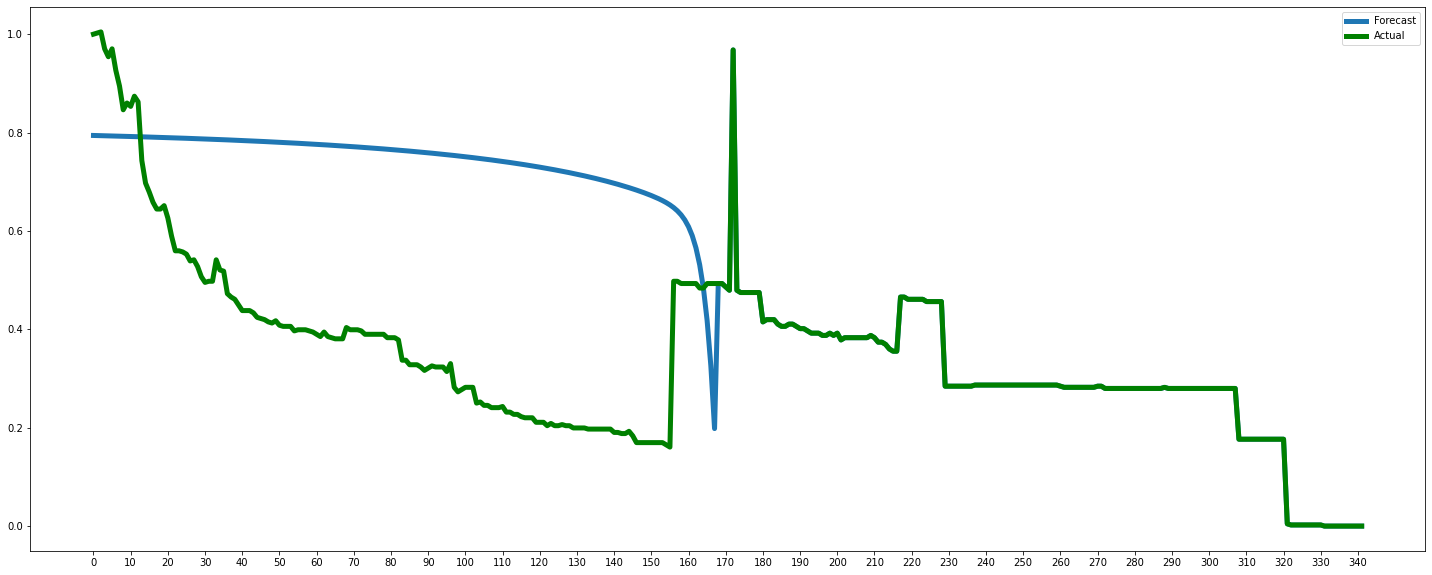

In [119]:
for v in range(df_val_dxb_xxx.shape[0]):
  df_val_dxb_xxx.loc[v,'0':str(last_available_data)] = _Y_val_dxb_xxx[v].reshape(-1)[::-1]
  rmse = sqrt(mean_squared_error(_df_val_dxb_xxx.loc[v,'0':'341'].values, df_val_dxb_xxx.loc[v,'0':'341'].values))
  df_val_dxb_xxx.loc[v,'RMSE']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_val_dxb_xxx.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Forecast')
  plt.plot(_df_val_dxb_xxx.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Actual')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

In [120]:
df_val_dxb_xxx['RMSE'].mean()

0.1337221862809779

In [124]:
model_xxx_dxb = Sequential()
model_xxx_dxb.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_xxx_dxb.add(RepeatVector(n_lookup))
model_xxx_dxb.add(LSTM(100, activation='tanh', return_sequences=True))
model_xxx_dxb.add(TimeDistributed(Dense(1)))
model_xxx_dxb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')

model_xxx_dxb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVector  (None, 168, 100)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 168, 100)          80400     
                                                                 
 time_distributed (TimeDistr  (None, 168, 1)           101       
 ibuted)                                                         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


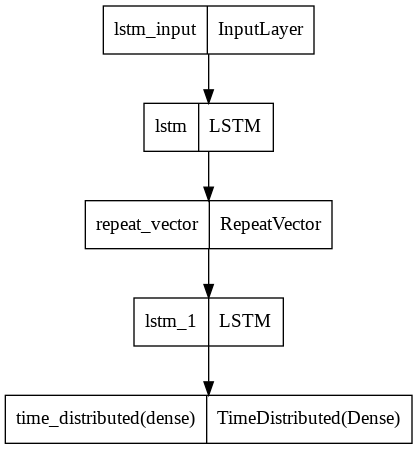

In [125]:
tf.keras.utils.plot_model(model_xxx_dxb)

In [126]:

es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

def plot_model_learning(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [127]:
N_SAMPLE = 20
#yhat_tcm = np.zeros((Xtest_sub.shape[0],n_lookup))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_xxx_dxb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')
    history_tcm = model_xxx_dxb.fit(X_train_xxx_dxb, Y_train_xxx_dxb, 
                                validation_data = (X_val_xxx_dxb, Y_val_xxx_dxb), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    #yhat_tcm += np.expm1(model_tcm.predict(Xtest_sub)).reshape(-1,n_lookup)

#yhat_tcm = yhat_tcm / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

In [128]:
_Y_val_xxx_dxb = model_xxx_dxb.predict(X_val_xxx_dxb)

1/1 [==============================] - 1s 1s/step


In [129]:
df_val_xxx_dxb.shape

(30, 348)

In [130]:
for n, i in df_val_xxx_dxb.iterrows():
  df_val_xxx_dxb.loc[n,'0':str(last_available_data)] = _Y_val_xxx_dxb[n].reshape(-1)[::-1]

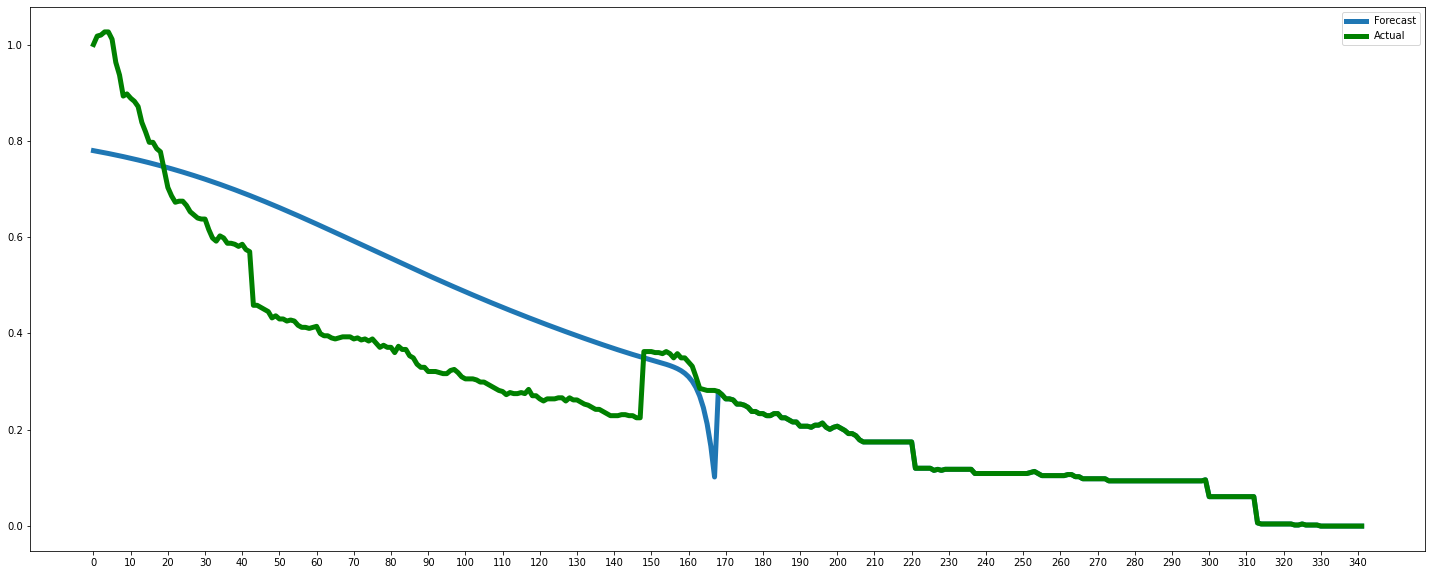

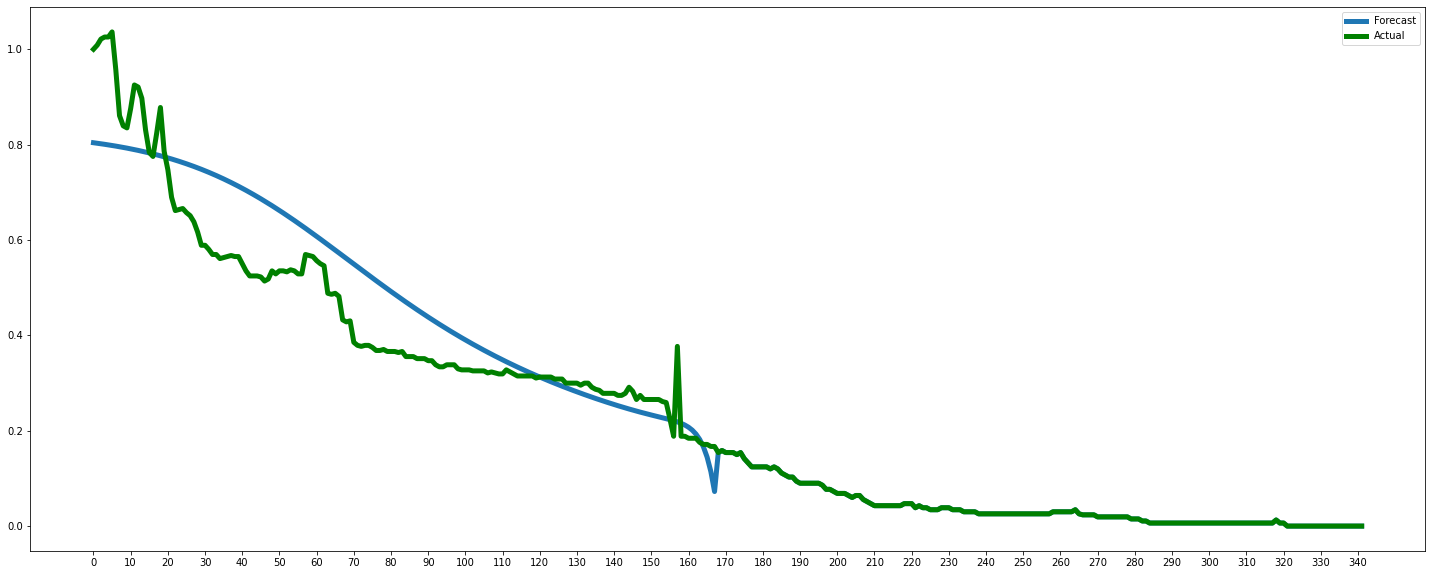

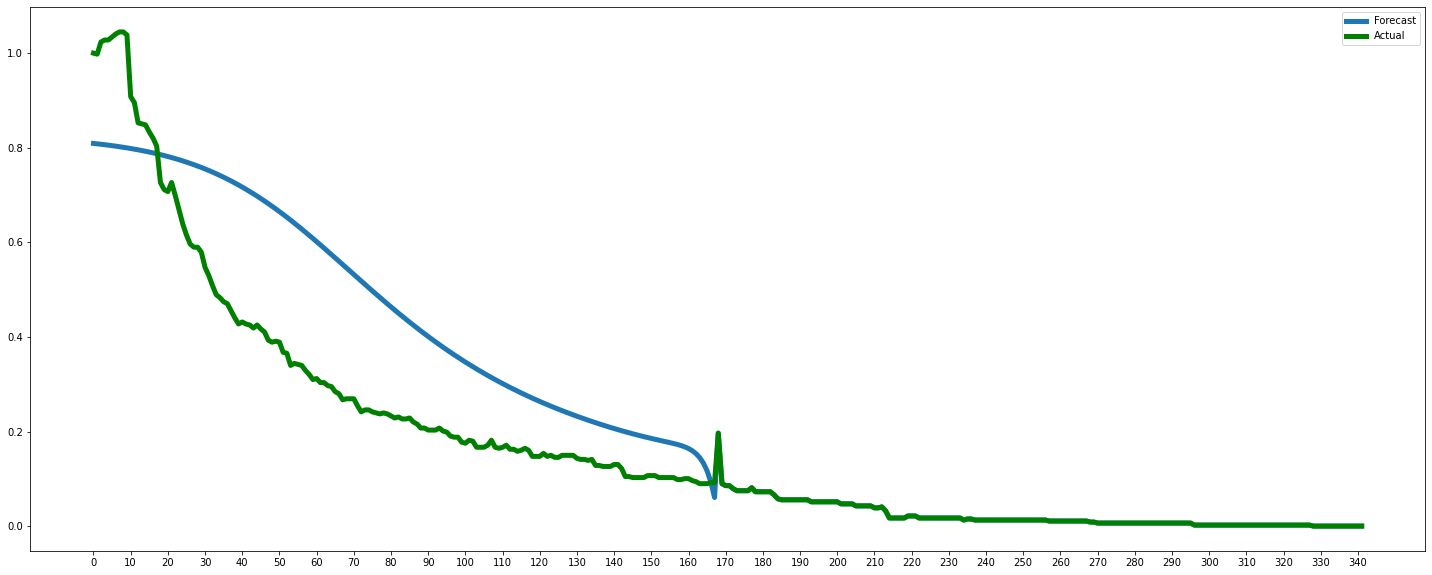

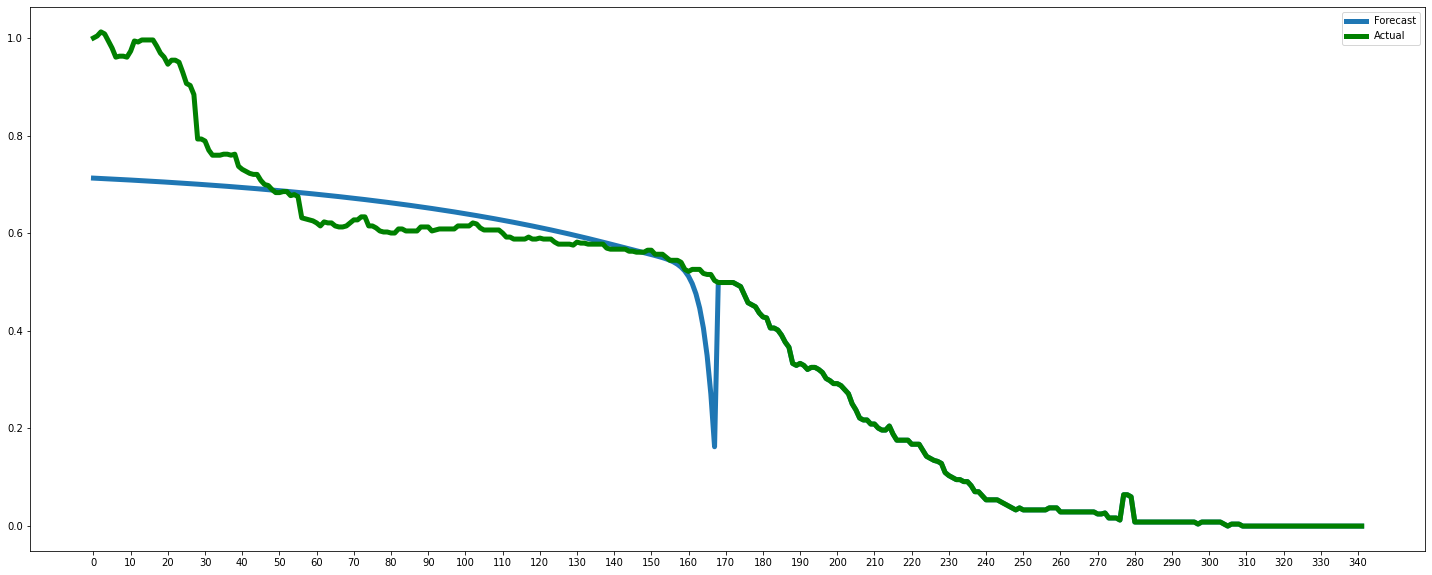

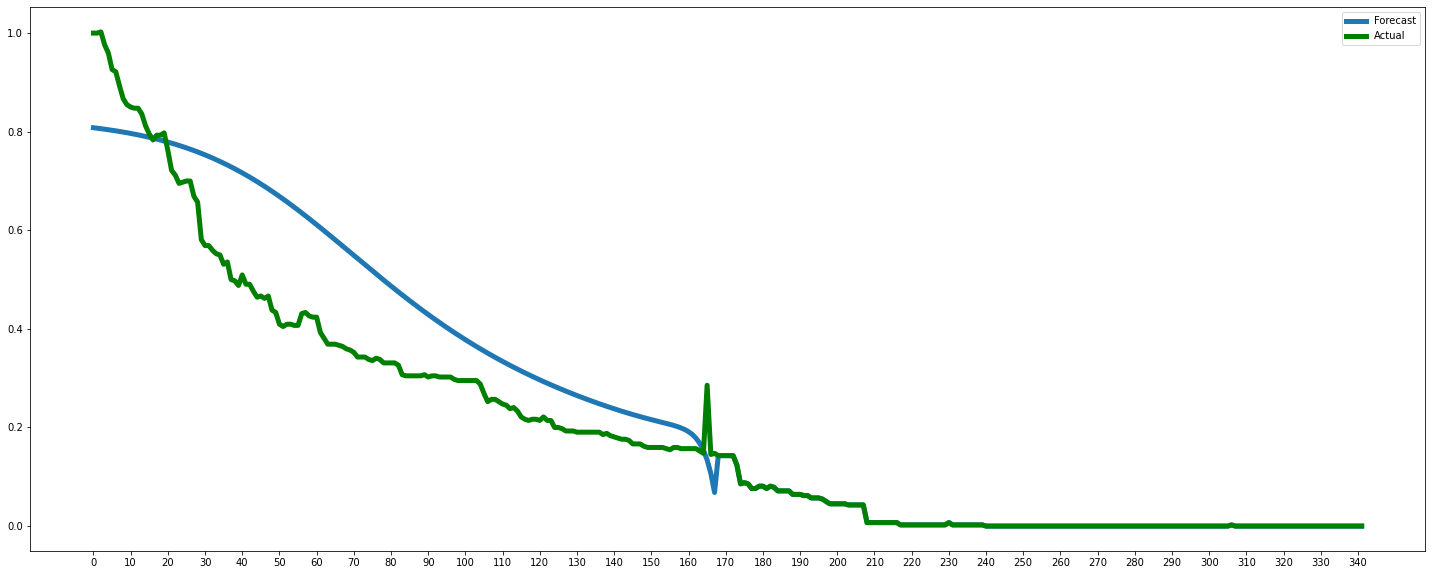

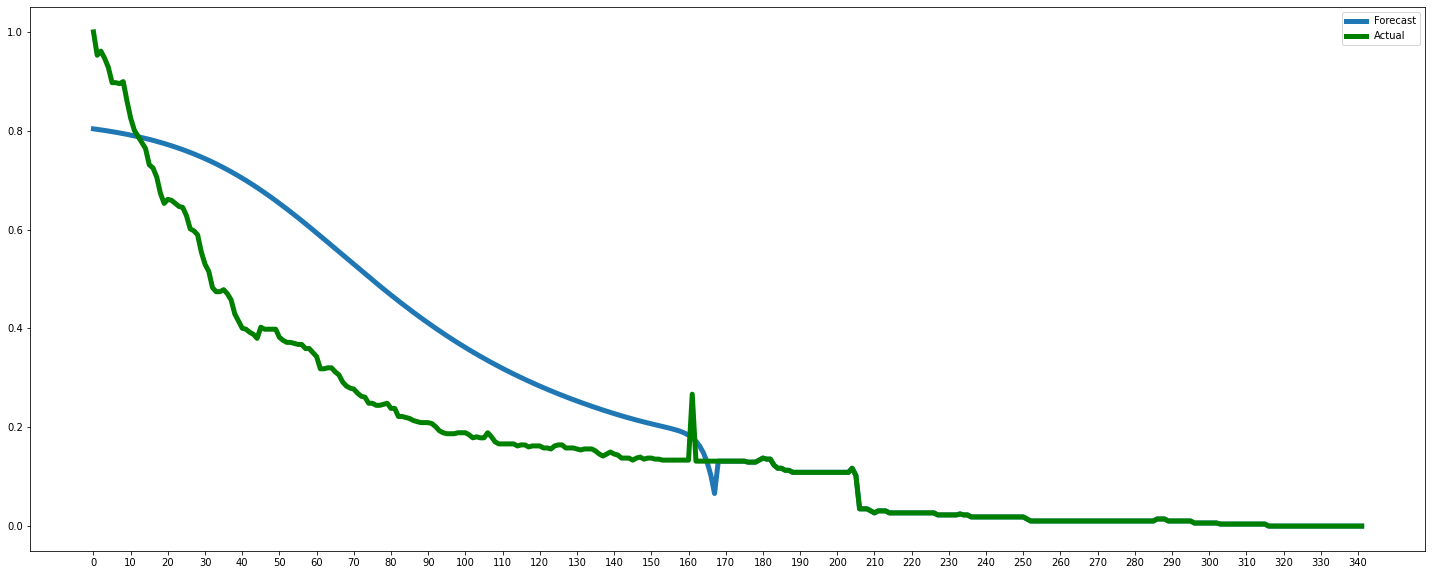

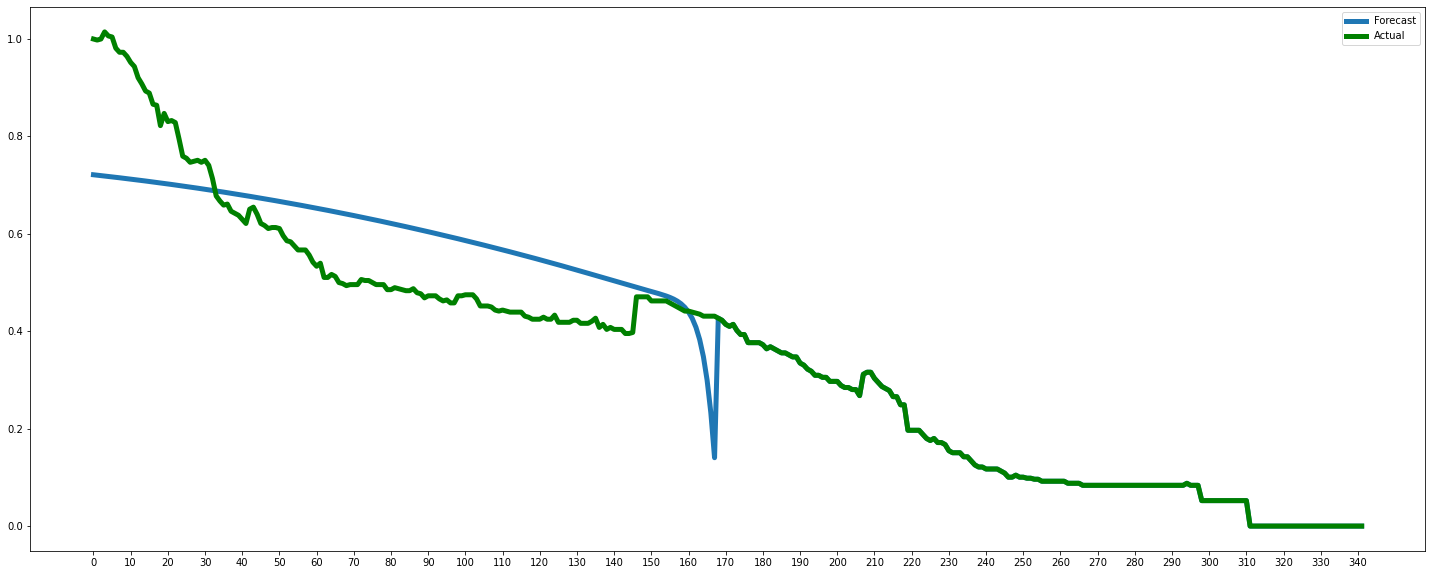

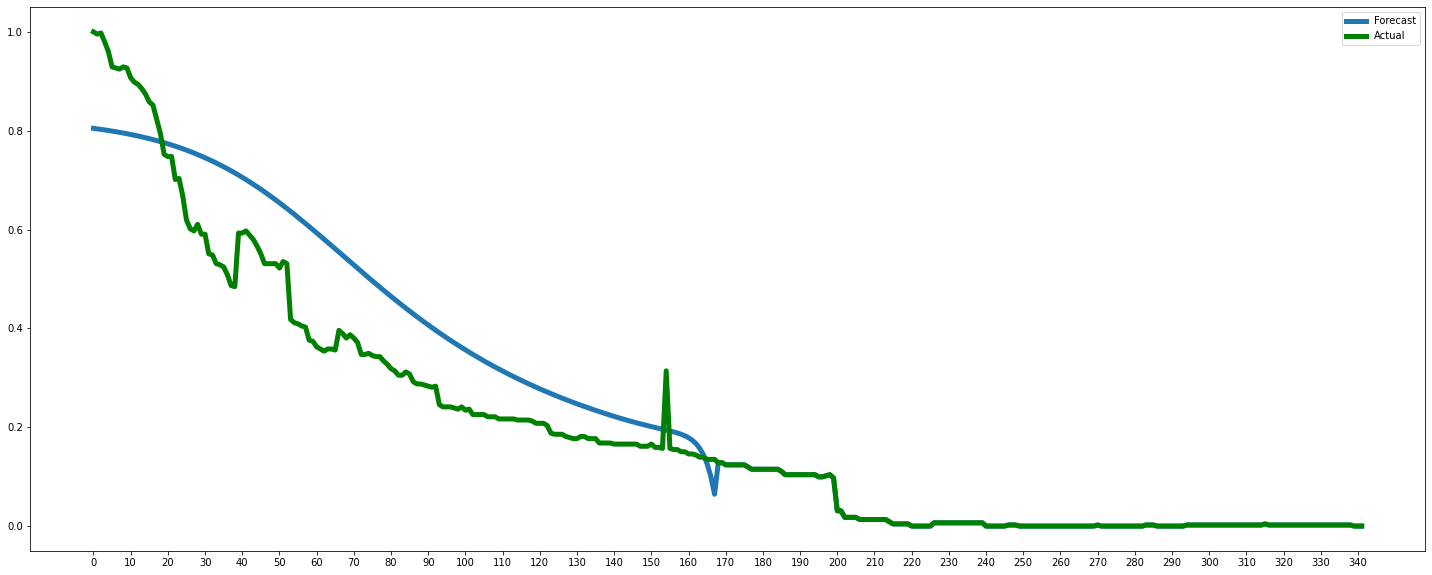

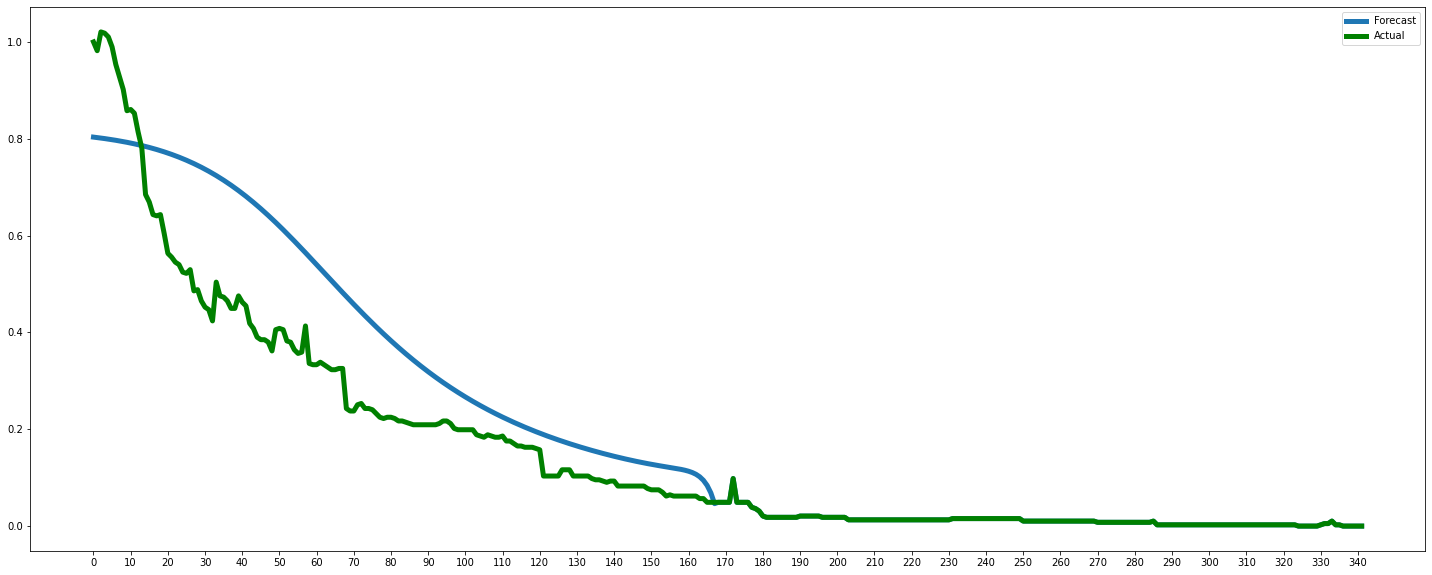

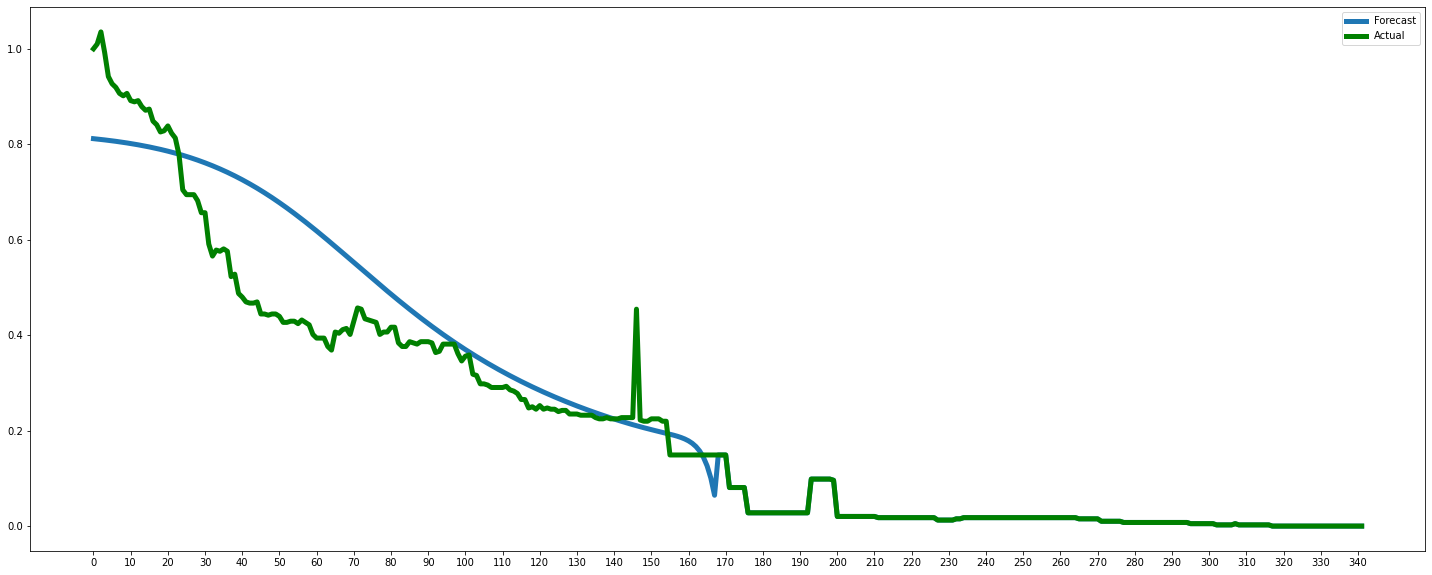

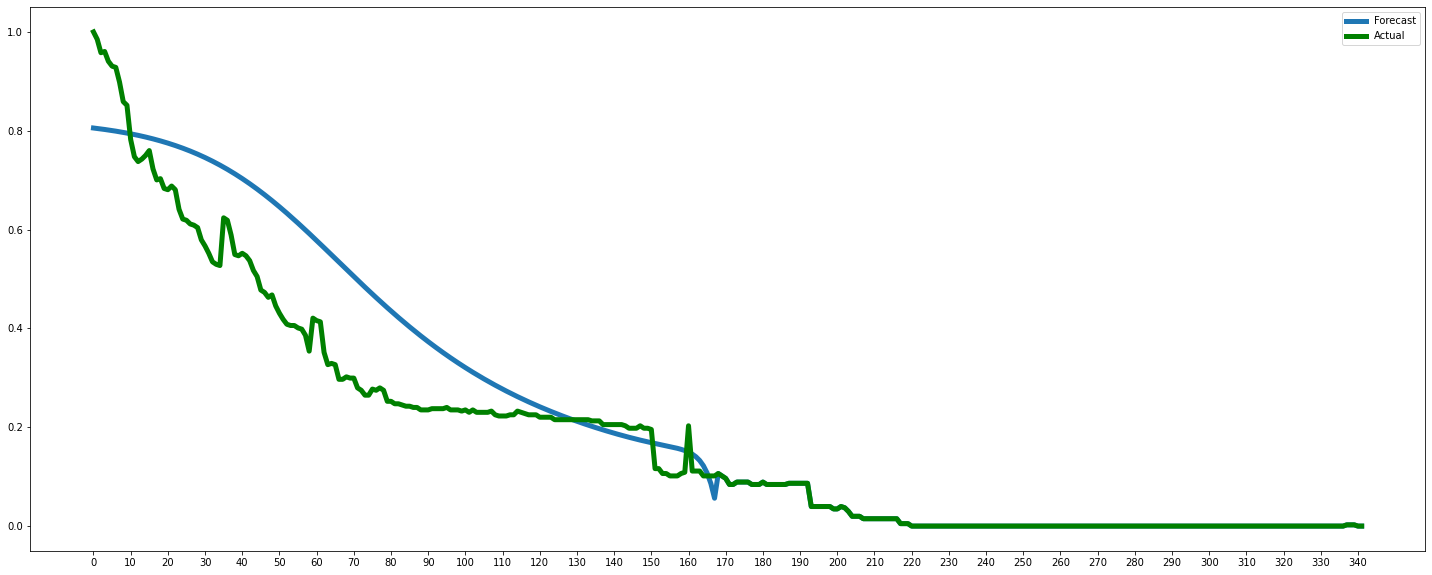

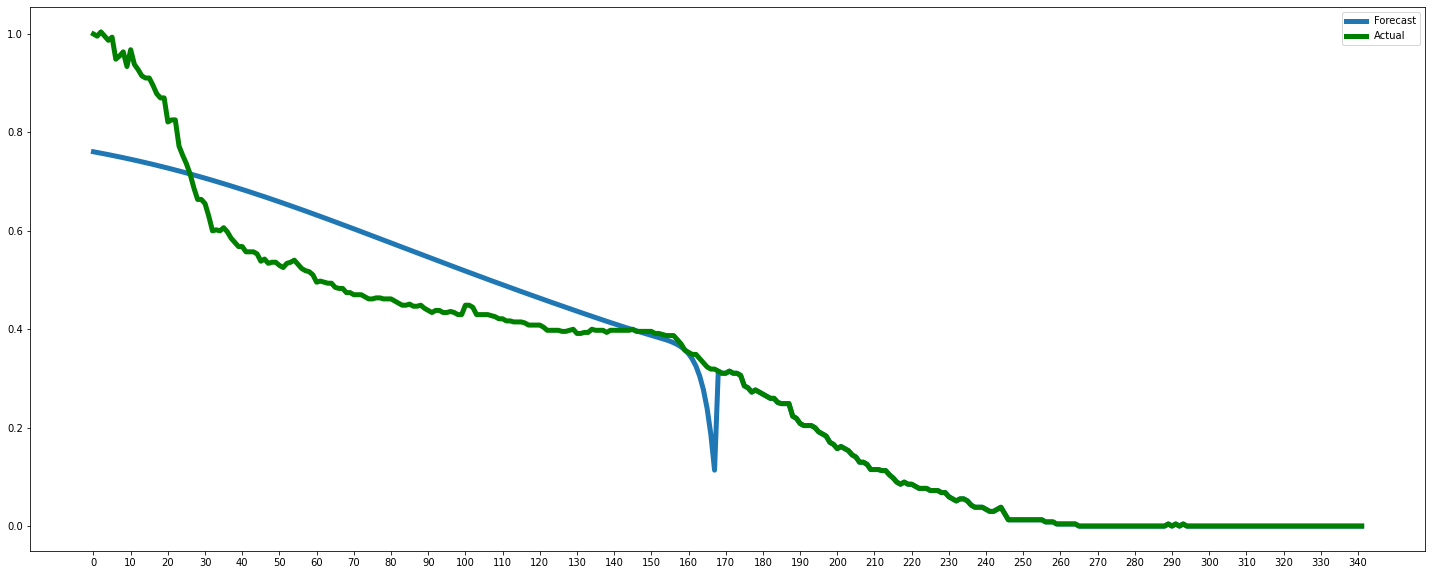

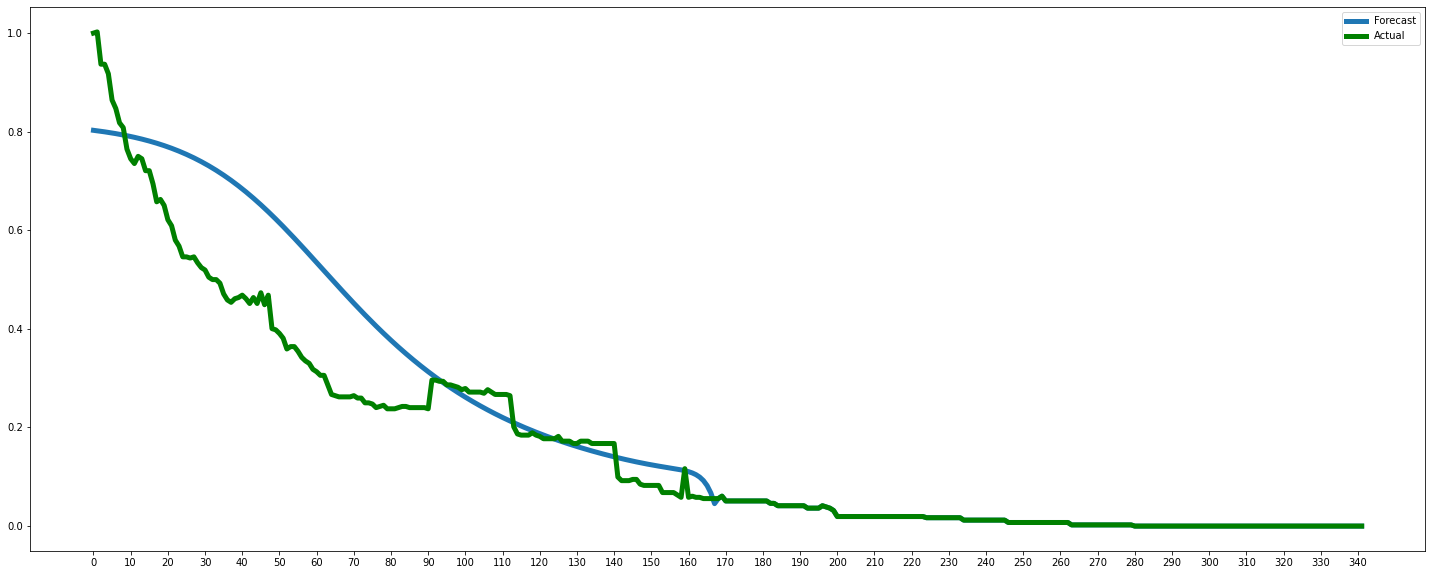

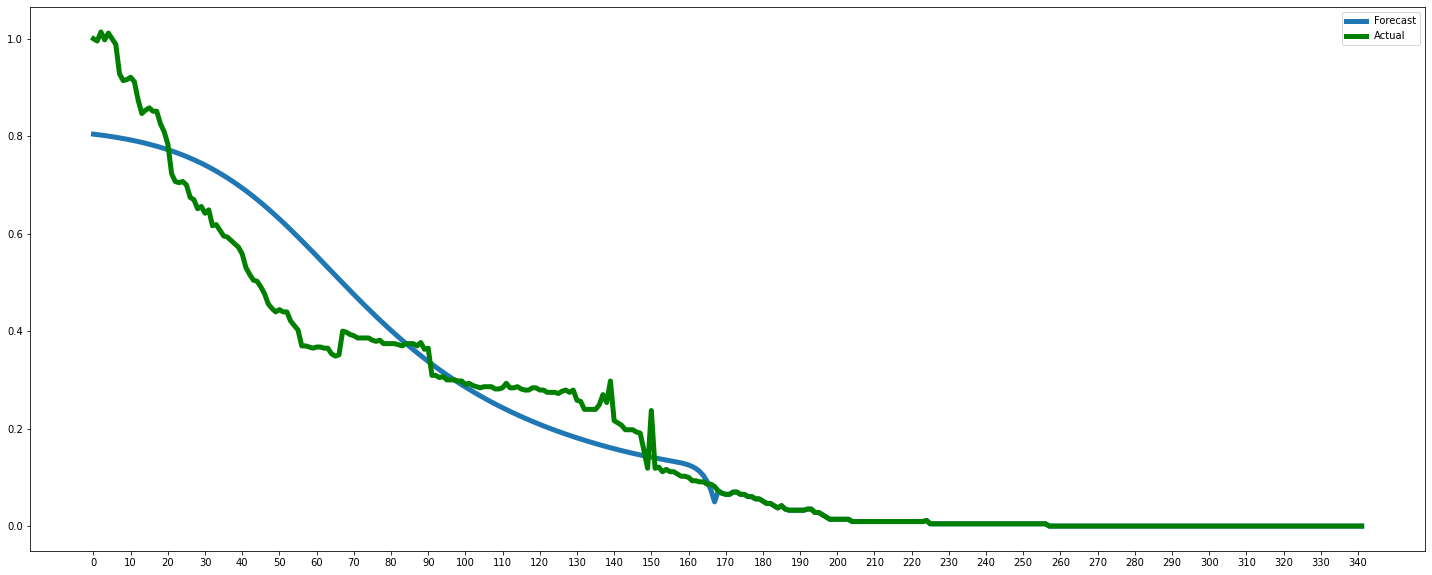

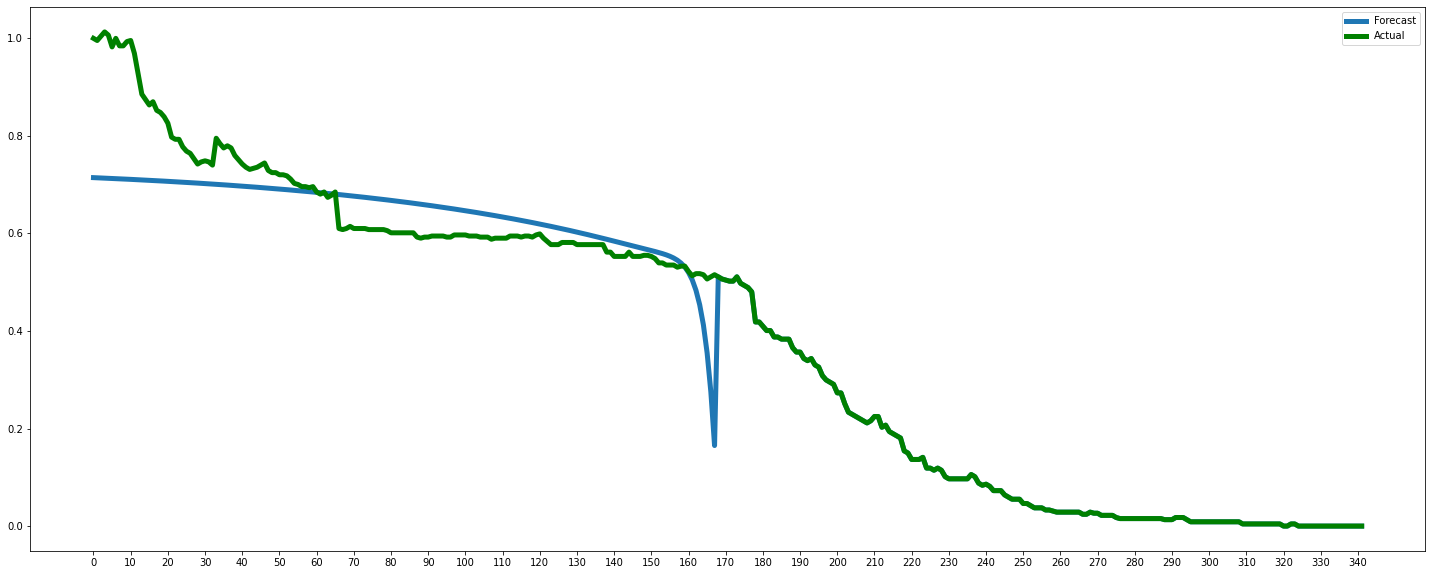

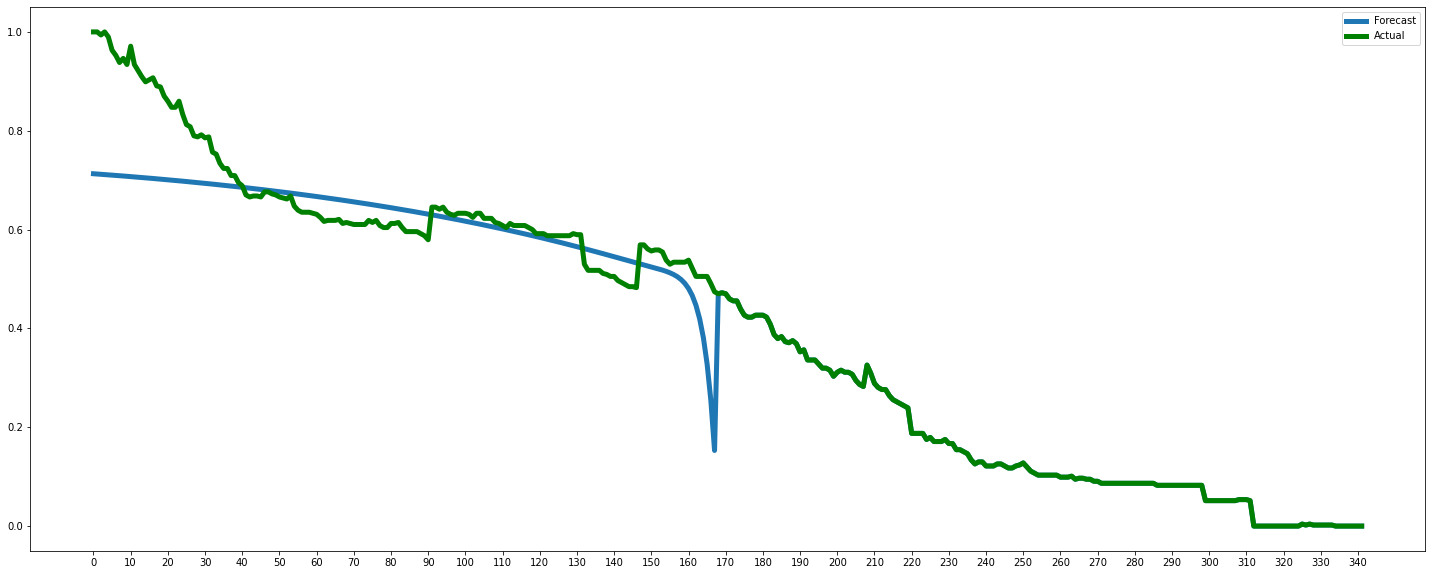

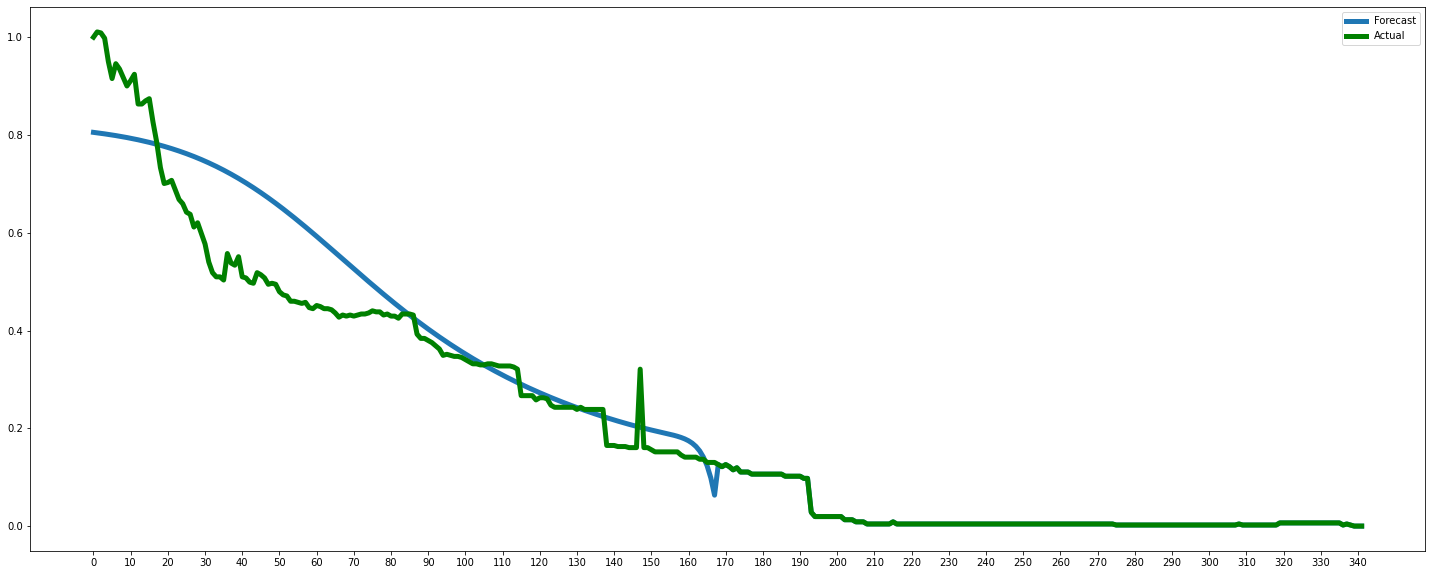

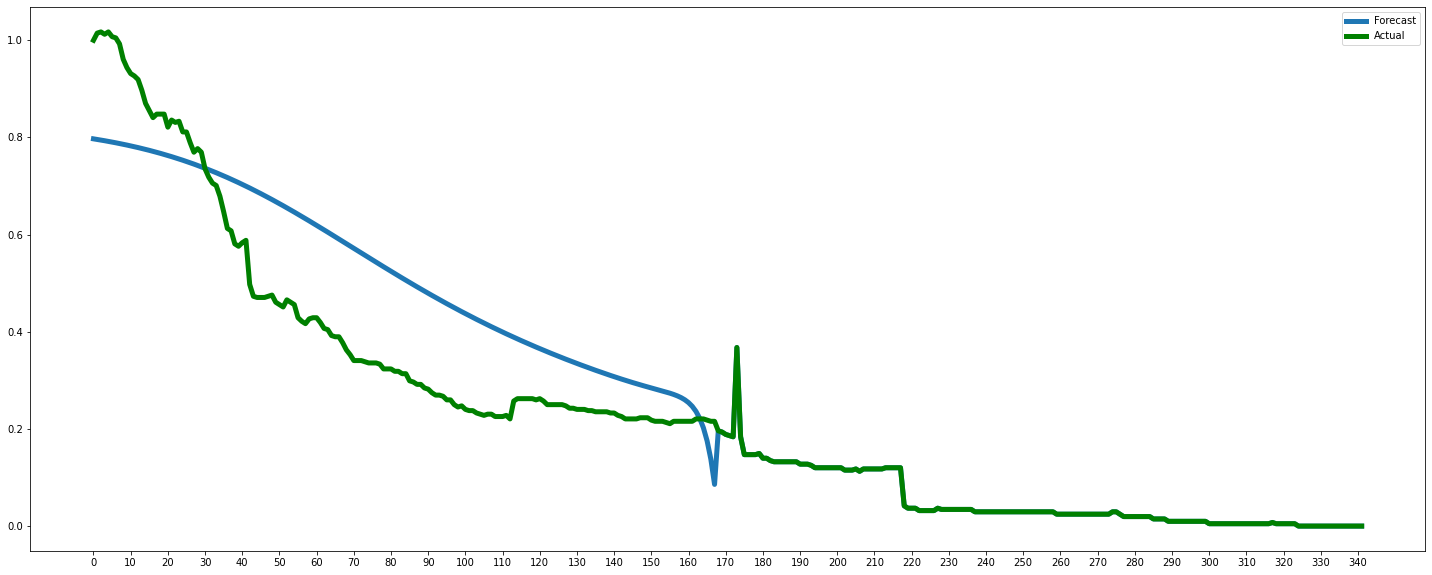

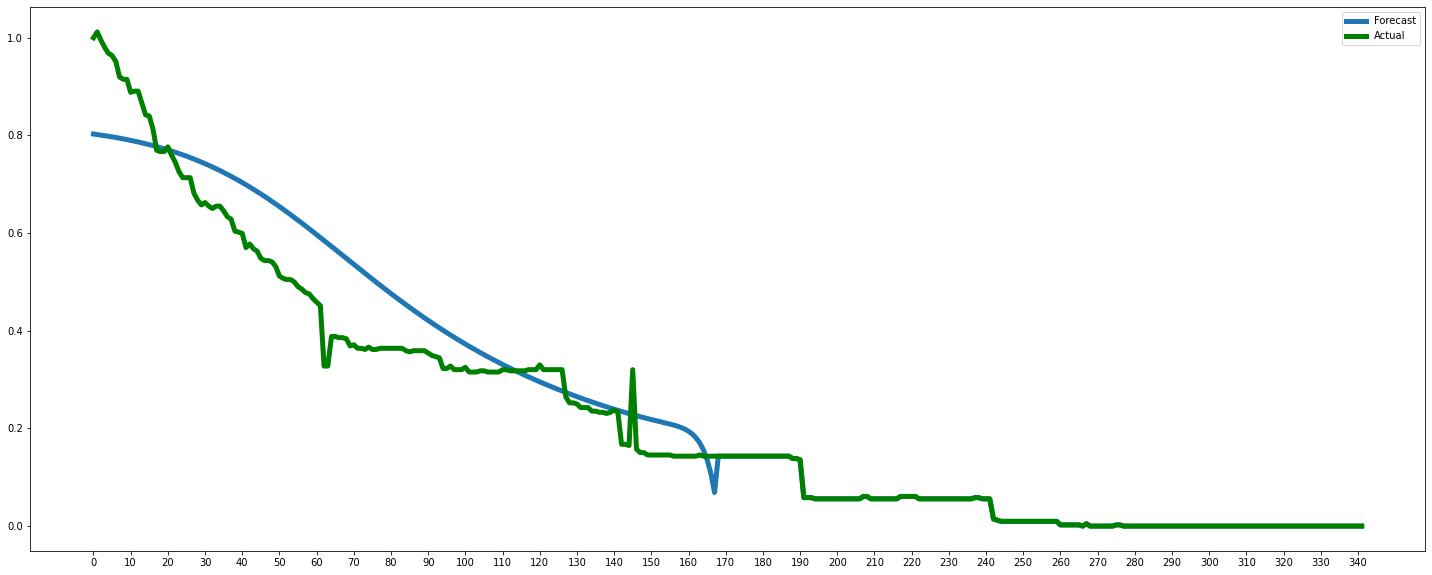

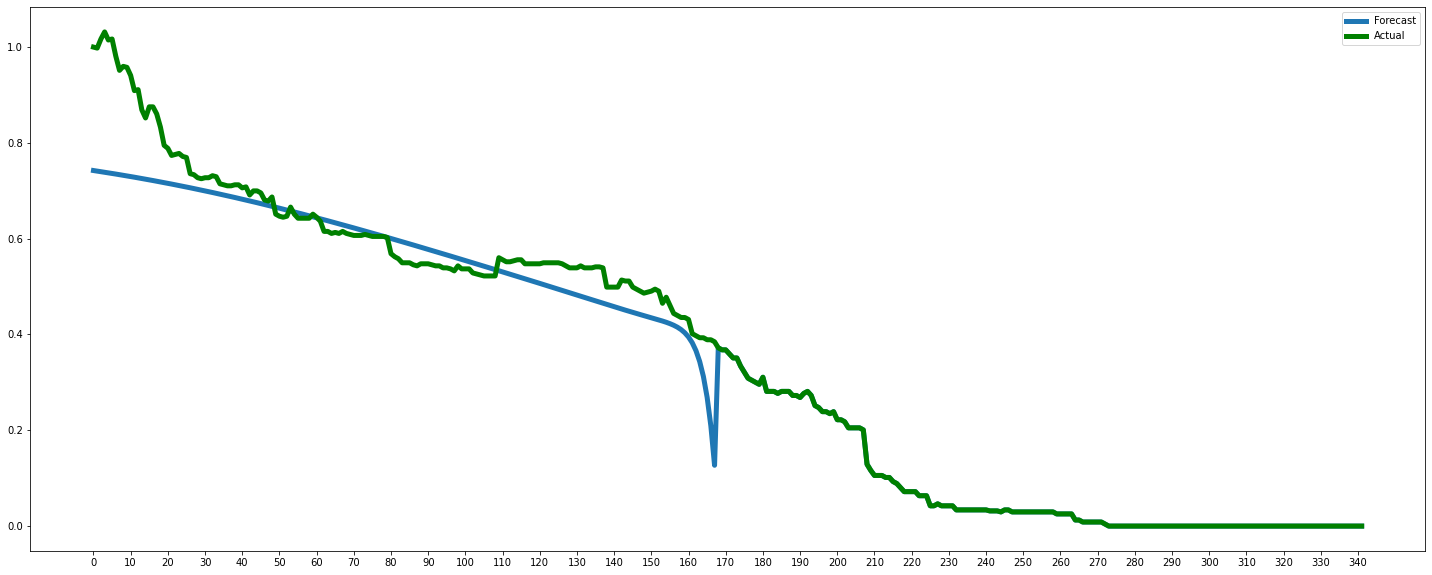

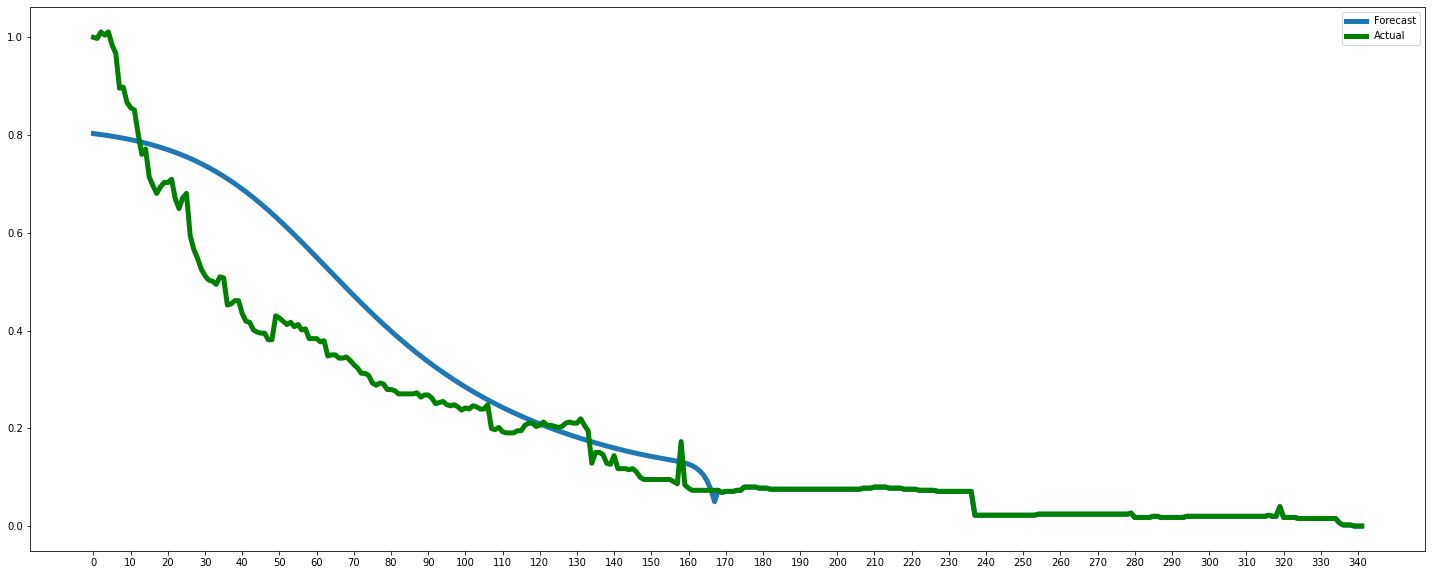

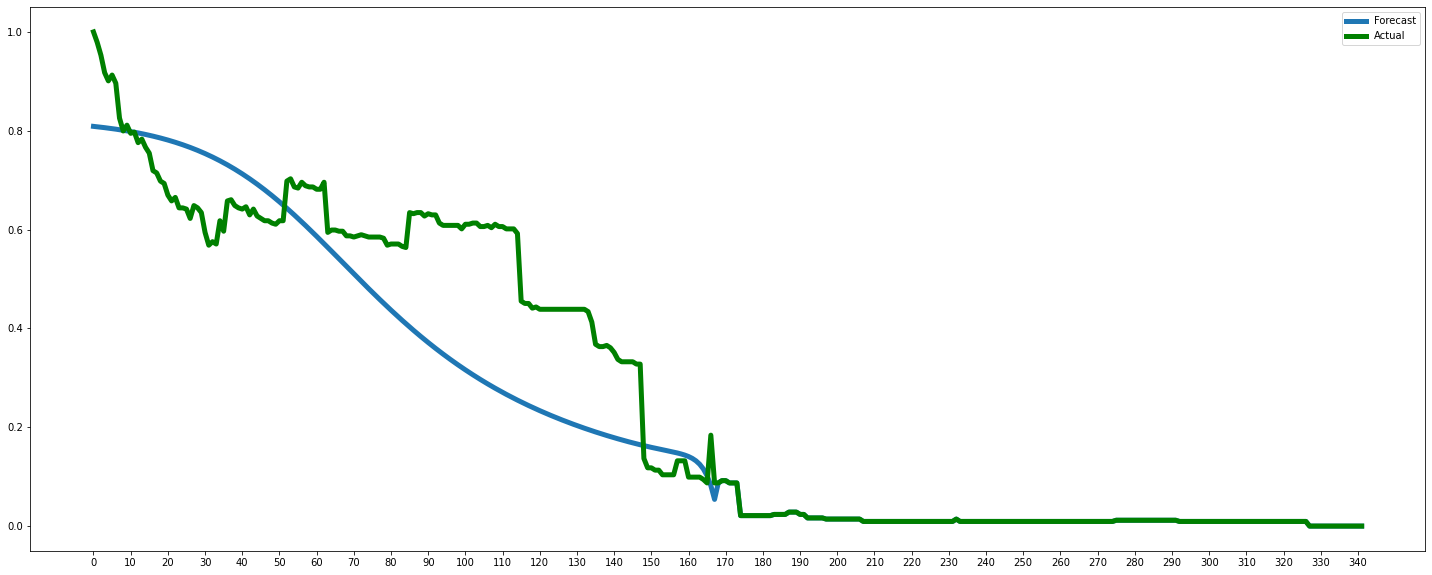

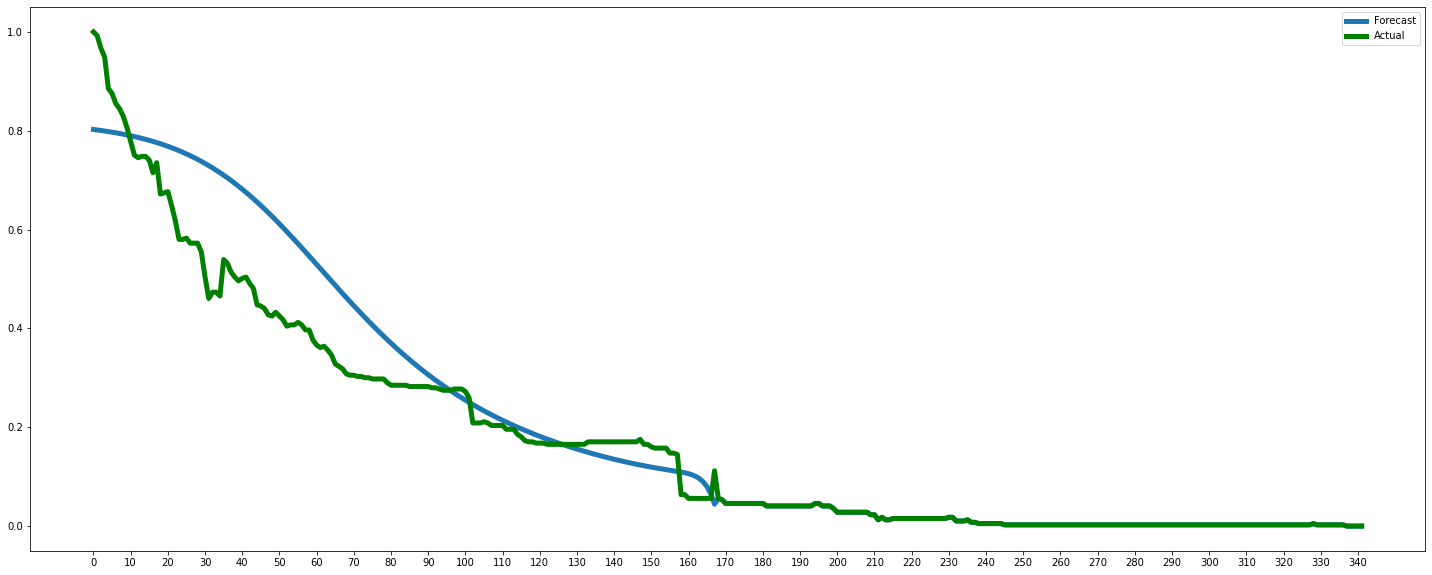

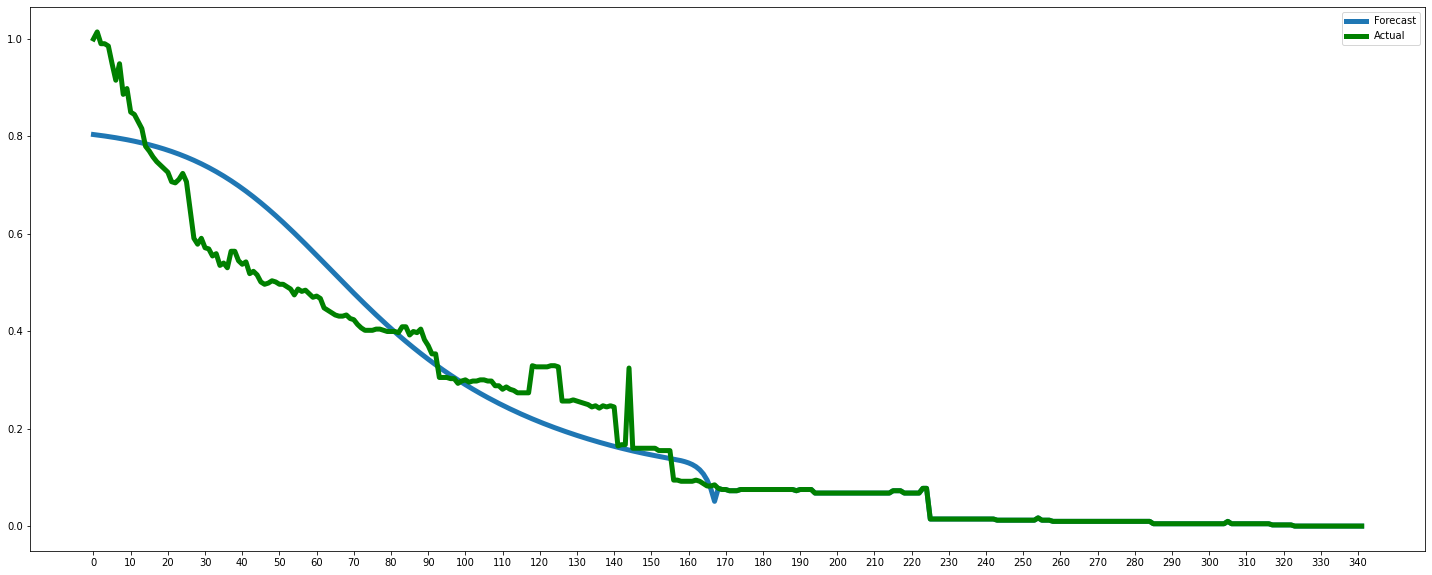

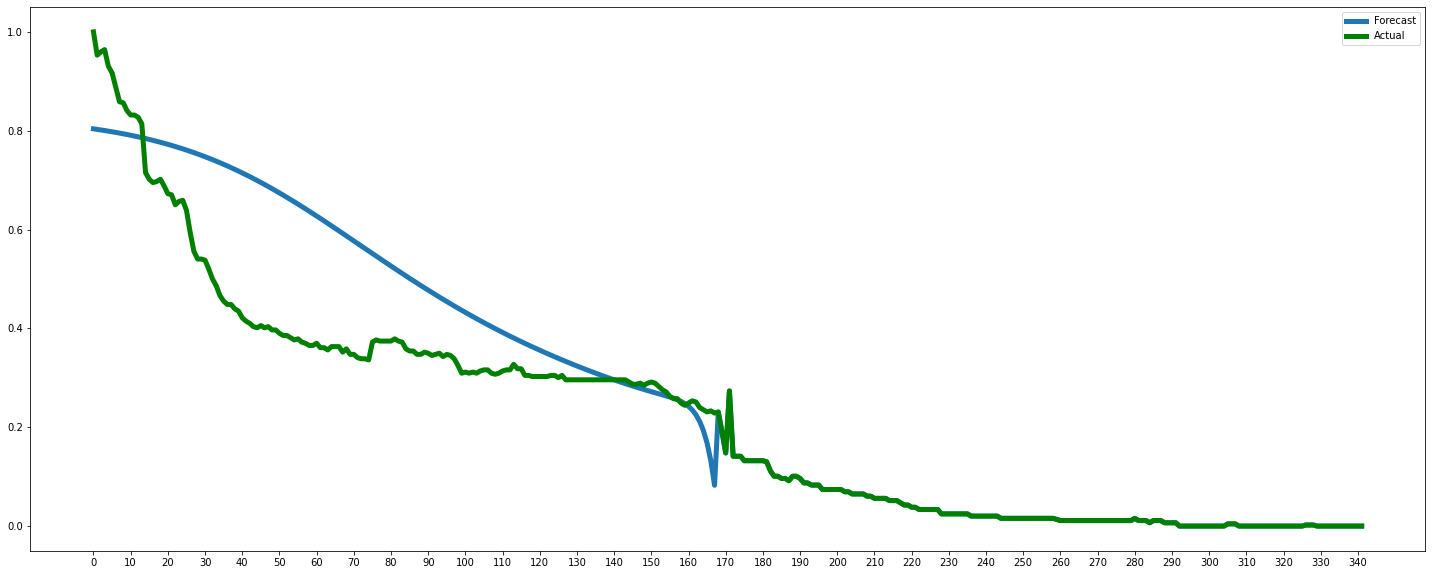

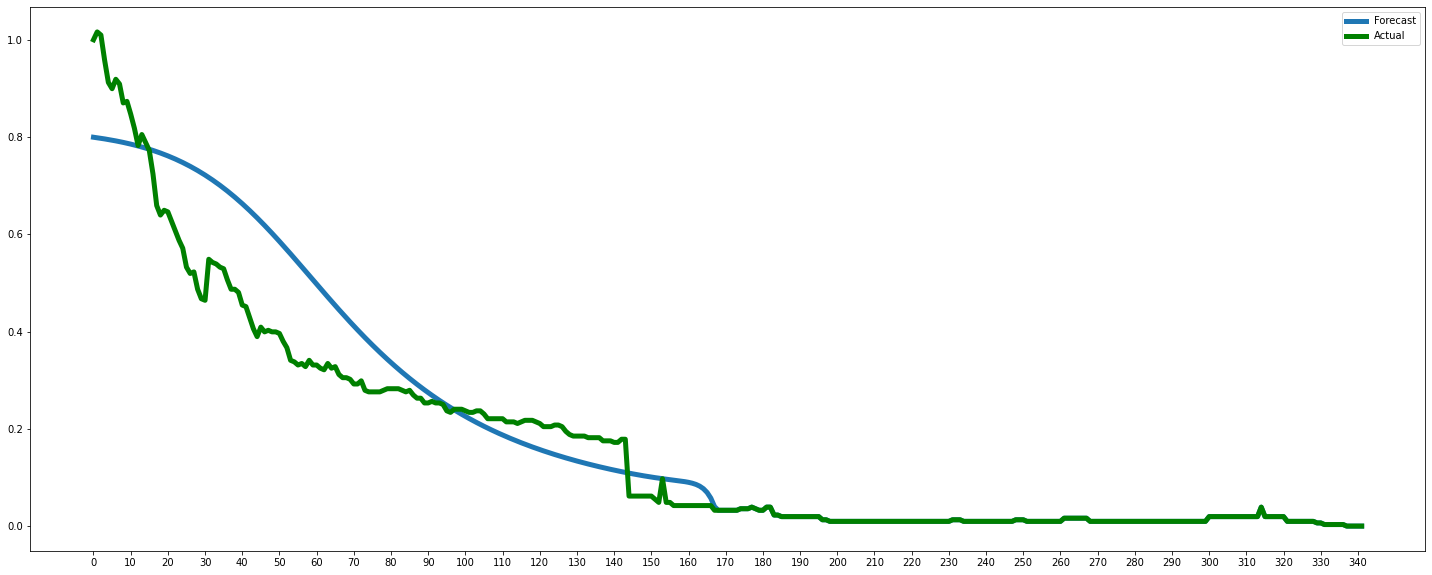

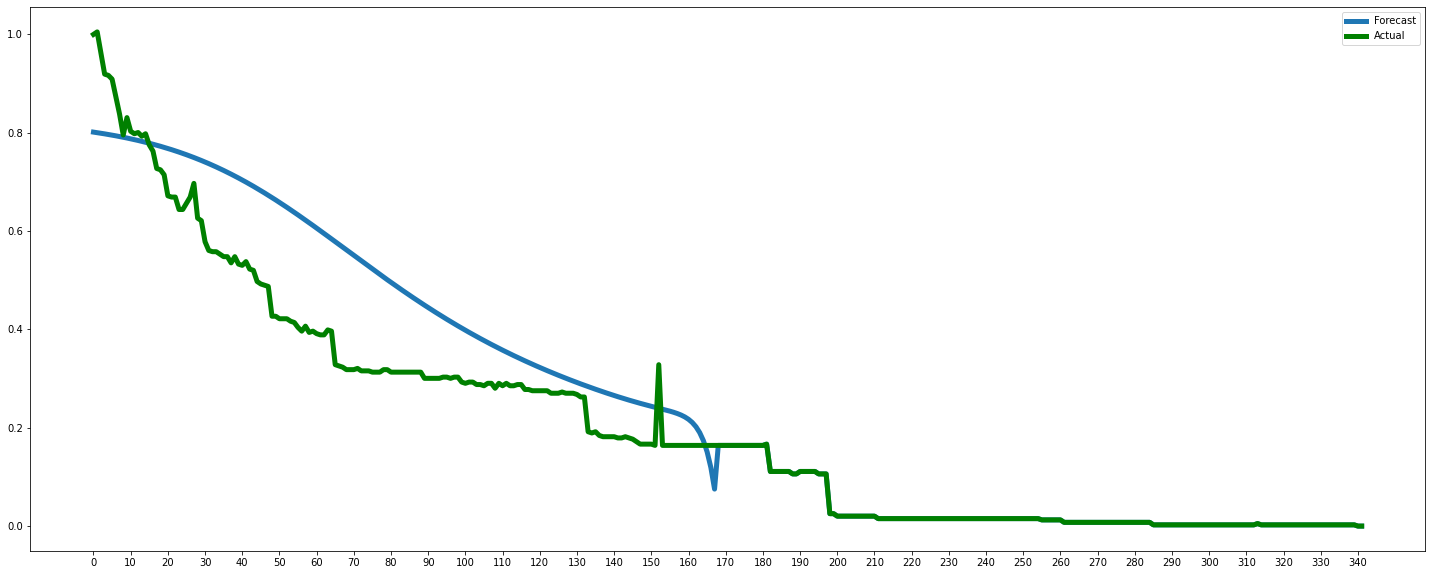

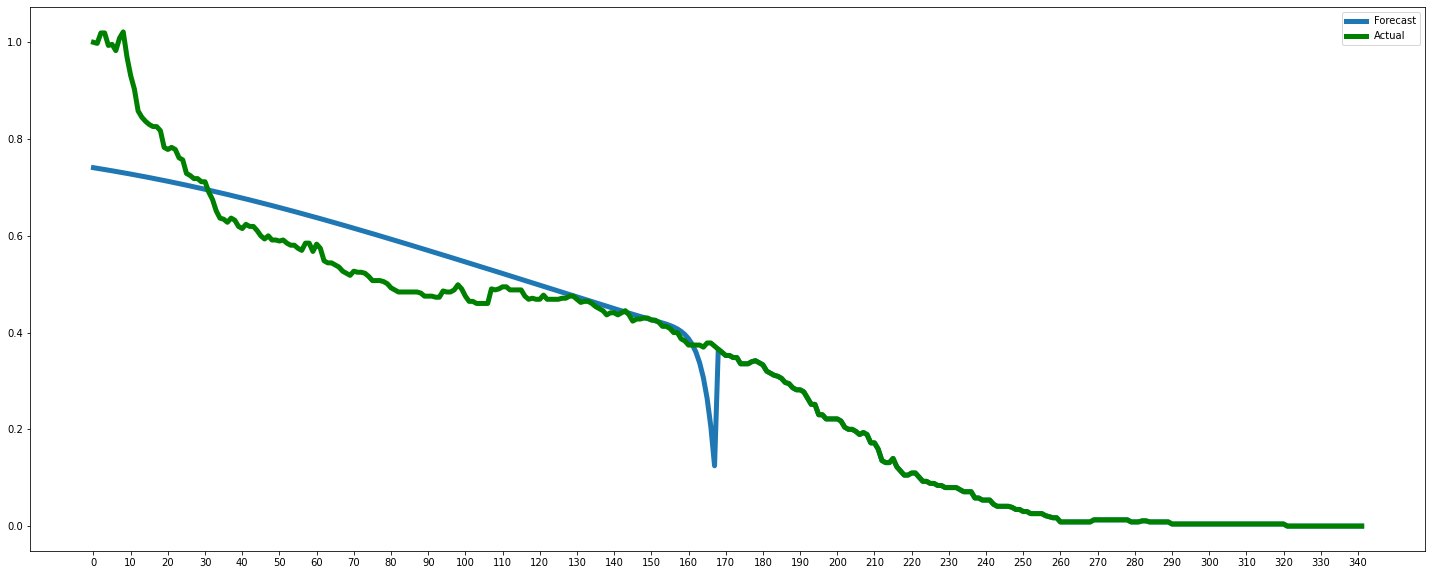

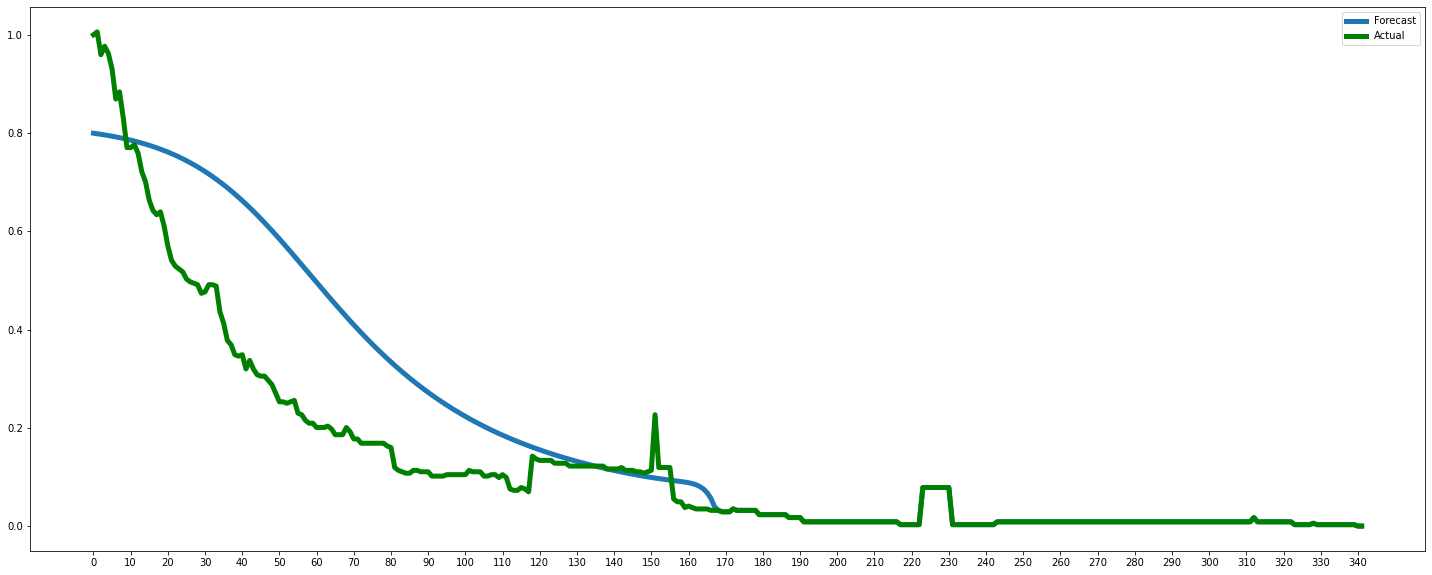

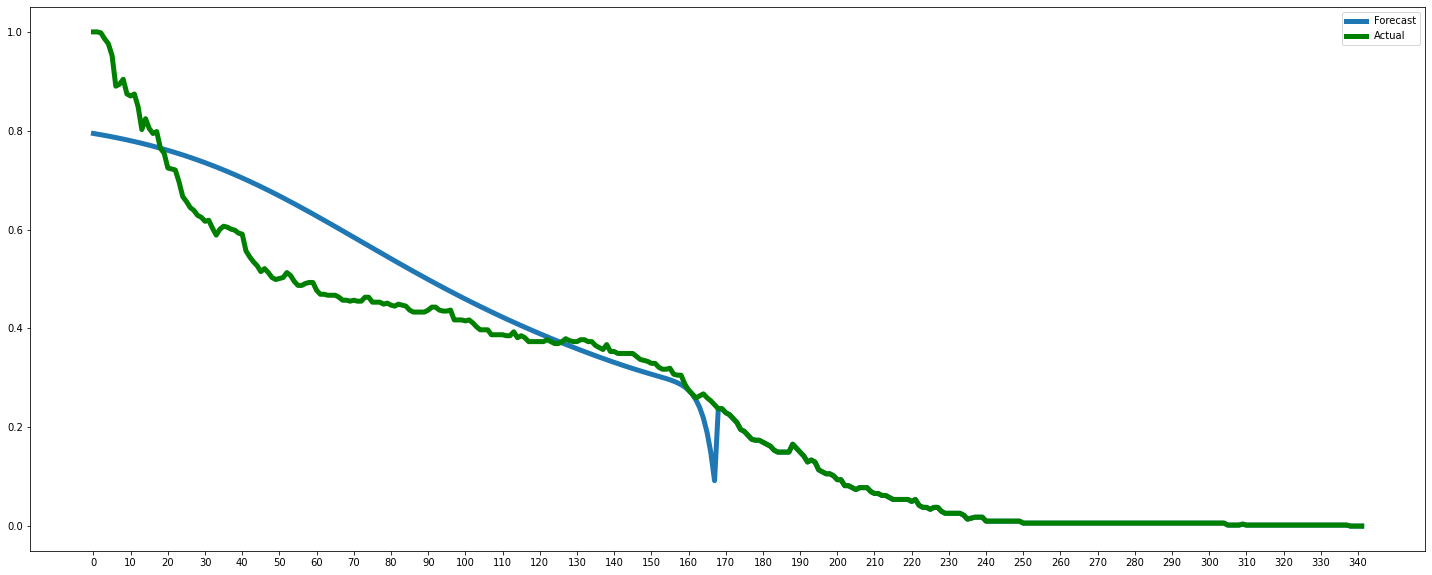

In [131]:
for v in range(df_val_xxx_dxb.shape[0]):
  df_val_xxx_dxb.loc[v,'0':str(last_available_data)] = _Y_val_xxx_dxb[v].reshape(-1)[::-1]
  rmse = sqrt(mean_squared_error(_df_val_xxx_dxb.loc[v,'0':'341'].values, df_val_xxx_dxb.loc[v,'0':'341'].values))
  df_val_xxx_dxb.loc[v,'RMSE']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_val_xxx_dxb.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Forecast')
  plt.plot(_df_val_xxx_dxb.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Actual')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

In [132]:
df_val_xxx_dxb['RMSE'].mean()

0.08884519456140814